In [ ]:
!pip install opencv-python scikit-image scikit-learn tensorflow


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from skimage.measure import shannon_entropy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from skimage.feature import graycomatrix, graycoprops

In [ ]:
# Define dataset paths (replace with your actual path)
original_path = '/content/drive/MyDrive/Datasets/QR_Classifier/First Print'
counterfeit_path = '/content/drive/MyDrive/Datasets/QR_Classifier/Second Print'

Original QR codes: 100
Counterfeit QR codes: 103


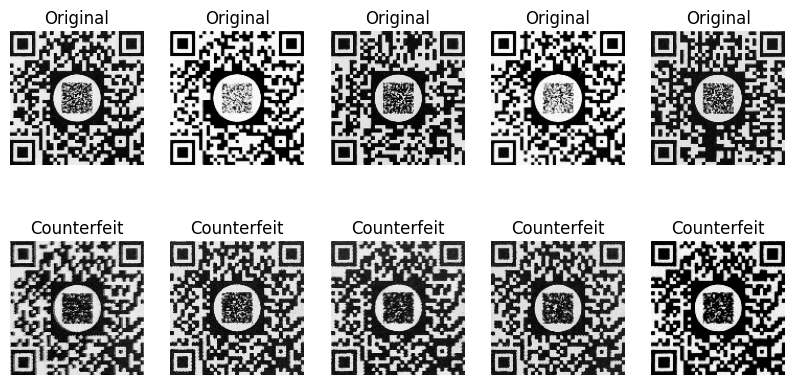

In [ ]:
# Load images
def load_images(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (128, 128))  # Resize for consistency
            images.append(img)
            labels.append(label)
    return images, labels

# Load original (class 0) and counterfeit (class 1) images
original_images, original_labels = load_images(original_path, 0)
counterfeit_images, counterfeit_labels = load_images(counterfeit_path, 1)

# Combine data
X = np.array(original_images + counterfeit_images)
y = np.array(original_labels + counterfeit_labels)

# Check dataset balance
print(f"Original QR codes: {len(original_images)}")
print(f"Counterfeit QR codes: {len(counterfeit_images)}")

# Visualize samples
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(original_images[i], cmap='gray')
    plt.title("Original")
    plt.axis('off')
    plt.subplot(2, 5, i+6)
    plt.imshow(counterfeit_images[i], cmap='gray')
    plt.title("Counterfeit")
    plt.axis('off')
plt.show()

In [ ]:
# Feature extraction function
def extract_features(image):
    features = []
    # Blur (Laplacian variance)
    features.append(cv2.Laplacian(image, cv2.CV_64F).var())
    # Entropy
    features.append(shannon_entropy(image))
    # Average intensity
    features.append(np.mean(image))
    # GLCM (texture features)
    # glcm = greycomatrix(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    glcm = graycomatrix(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    features.append(graycoprops(glcm, 'contrast')[0, 0])
    features.append(graycoprops(glcm, 'correlation')[0, 0])
    features.append(graycoprops(glcm, 'energy')[0, 0])
    features.append(graycoprops(glcm, 'homogeneity')[0, 0])

    lbp = local_binary_pattern(image, P=8, R=1, method='uniform')
    hist, _ = np.histogram(lbp, bins=np.arange(0, 10), density=True)
    features.extend(hist)
    return features

# Extract features for all images
X_features = np.array([extract_features(img) for img in X])

# Split into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Evaluate
y_pred_rf = rf.predict(X_test_scaled)
print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.95      1.00      0.98        20

    accuracy                           0.98        41
   macro avg       0.98      0.98      0.98        41
weighted avg       0.98      0.98      0.98        41

Confusion Matrix:
 [[20  1]
 [ 0 20]]


In [ ]:
# Reshape data for CNN
X_cnn = X.reshape(-1, 128, 128, 1)  # Add channel dimension
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y, test_size=0.2, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

# CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train CNN
history = model.fit(
    datagen.flow(X_train_cnn, y_train_cnn, batch_size=32),
    epochs=50,
    validation_data=(X_test_cnn, y_test_cnn),
    callbacks=[EarlyStopping(patience=3)]
)

# Evaluate CNN
y_pred_cnn = (model.predict(X_test_cnn) > 0.5).astype(int)
print("CNN Results:")
print(classification_report(y_test_cnn, y_pred_cnn))
print("Confusion Matrix:\n", confusion_matrix(y_test_cnn, y_pred_cnn))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 622ms/step - accuracy: 0.5026 - loss: 511.9000 - val_accuracy: 0.5122 - val_loss: 15.9423
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5477 - loss: 56.1763 - val_accuracy: 0.4878 - val_loss: 14.0202
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5682 - loss: 7.5139 - val_accuracy: 0.3902 - val_loss: 1.8710
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4891 - loss: 1.1901 - val_accuracy: 0.4878 - val_loss: 1.2297
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5202 - loss: 0.9277 - val_accuracy: 0.6585 - val_loss: 0.6567
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5986 - loss: 0.6526 - val_accuracy: 0.4878 - val_loss: 0.7491
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5330 - loss: 0.6604 - val_accuracy: 0.6829 - val_loss: 0.6190
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.6130 - loss: 0.6522 - val_accuracy: 0.7073 - val_loss: 0.5998
Epoch

Random Forest Accuracy: 0.98
CNN Accuracy: 0.46


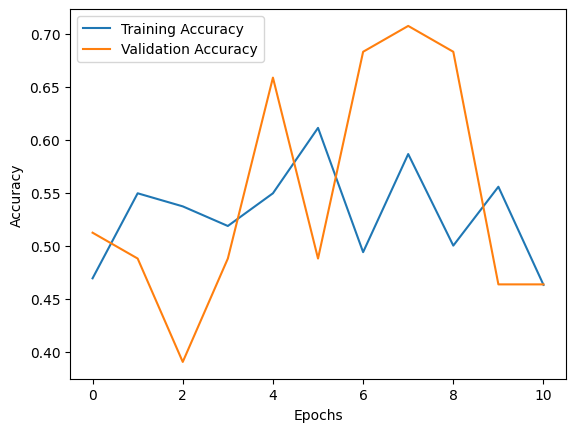

In [ ]:
# Compare accuracy
rf_accuracy = accuracy_score(y_test, y_pred_rf)
cnn_accuracy = accuracy_score(y_test_cnn, y_pred_cnn)
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")
print(f"CNN Accuracy: {cnn_accuracy:.2f}")

# Plot training history (for CNN)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
def create_improved_cnn(input_shape):
    model = Sequential([
        # First convolution block
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),

        # Second convolution block
        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),

        # Third convolution block
        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),

        # Classifier head
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')])
    return model


In [ ]:
# Enhanced Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.9,1.1],
    shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=255  # Simulate scanner background
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Class weighting for imbalance (adjust based on your dataset)
class_weights = {0: 1., 1: 3.}  # Give more weight to minority class

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint


In [ ]:
# Callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=3),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]


In [ ]:
from tensorflow.keras.layers import BatchNormalization


In [ ]:
# Create and train improved model
improved_model = create_improved_cnn((128, 128, 1))

In [ ]:
history = improved_model.fit(
    train_datagen.flow(X_train_cnn, y_train_cnn, batch_size=32),
    steps_per_epoch=len(X_train_cnn) // 32,
    epochs=100,
    validation_data=test_datagen.flow(X_test_cnn, y_test_cnn),
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4519 - loss: 2.6554 - precision: 0.3435 - recall: 0.3785

5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.4638 - loss: 2.6890 - precision: 0.3772 - recall: 0.4036 - val_accuracy: 0.4878 - val_loss: 1.1959 - val_precision: 0.4878 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6250 - loss: 1.8832 - precision: 0.5882 - recall: 0.6667 - val_accuracy: 0.4878 - val_loss: 1.1980 - val_precision: 0.4878 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.6250 - loss: 2.7863 - precision: 0.6429 - recall: 0.5625

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6406 - loss: 2.2604 - precision: 0.6667 - recall: 0.6073 - val_accuracy: 0.4878 - val_loss: 1.1987 - val_precision: 0.4878 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.5593 - precision: 1.0000 - recall: 1.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 0.5593 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.4878 - val_loss: 1.1954 - val_precision: 0.4878 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6815 - loss: 2.0254 - precision: 0.7629 - recall: 0.6115

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.6782 - loss: 2.0202 - precision: 0.7552 - recall: 0.6120 - val_accuracy: 0.5122 - val_loss: 1.1893 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 6/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7188 - loss: 1.3781 - precision: 0.6111 - recall: 0.8462

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 762ms/step - accuracy: 0.7188 - loss: 1.3781 - precision: 0.6111 - recall: 0.8462 - val_accuracy: 0.5122 - val_loss: 1.1888 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7056 - loss: 1.6421 - precision: 0.7110 - recall: 0.7272 - val_accuracy: 0.4878 - val_loss: 1.1900 - val_precision: 0.4878 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7188 - loss: 1.6722 - precision: 0.7222 - recall: 0.7647 - val_accuracy: 0.4878 - val_loss: 1.1907 - val_precision: 0.4878 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7883 - loss: 1.2000 - precision: 0.7215 - recall: 0.8808 - val_accuracy: 0.4878 - val_loss: 1.1891 - val_precision: 0.4878 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accura

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.7341 - loss: 1.3664 - precision: 0.6680 - recall: 0.8459 - val_accuracy: 0.4878 - val_loss: 1.1861 - val_precision: 0.4878 - val_recall: 1.0000 - learning_rate: 2.5000e-05
Epoch 14/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8125 - loss: 1.7753 - precision: 0.8889 - recall: 0.8000

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.8125 - loss: 1.7753 - precision: 0.8889 - recall: 0.8000 - val_accuracy: 0.4878 - val_loss: 1.1848 - val_precision: 0.4878 - val_recall: 1.0000 - learning_rate: 2.5000e-05
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7481 - loss: 1.4104 - precision: 0.6171 - recall: 0.7133

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - accuracy: 0.7580 - loss: 1.4081 - precision: 0.6432 - recall: 0.7409 - val_accuracy: 0.7561 - val_loss: 1.1800 - val_precision: 0.6786 - val_recall: 0.9500 - learning_rate: 2.5000e-05
Epoch 16/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8125 - loss: 1.4309 - precision: 0.8235 - recall: 0.8235

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.8125 - loss: 1.4309 - precision: 0.8235 - recall: 0.8235 - val_accuracy: 0.7561 - val_loss: 1.1795 - val_precision: 0.6923 - val_recall: 0.9000 - learning_rate: 2.5000e-05
Epoch 17/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8450 - loss: 1.1605 - precision: 0.8582 - recall: 0.8621

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.8362 - loss: 1.1831 - precision: 0.8424 - recall: 0.8594 - val_accuracy: 0.5610 - val_loss: 1.1764 - val_precision: 1.0000 - val_recall: 0.1000 - learning_rate: 2.5000e-05
Epoch 18/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8125 - loss: 1.2915 - precision: 0.8750 - recall: 0.7778

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.8125 - loss: 1.2915 - precision: 0.8750 - recall: 0.7778 - val_accuracy: 0.5366 - val_loss: 1.1762 - val_precision: 1.0000 - val_recall: 0.0500 - learning_rate: 2.5000e-05
Epoch 19/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8289 - loss: 1.2655 - precision: 0.8447 - recall: 0.8521

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.8305 - loss: 1.2485 - precision: 0.8392 - recall: 0.8560 - val_accuracy: 0.5122 - val_loss: 1.1758 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 2.5000e-05
Epoch 20/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6875 - loss: 1.7908 - precision: 0.7368 - recall: 0.7368

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.6875 - loss: 1.7908 - precision: 0.7368 - recall: 0.7368 - val_accuracy: 0.5122 - val_loss: 1.1756 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 2.5000e-05
Epoch 21/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.8035 - loss: 1.3215 - precision: 0.7650 - recall: 0.8657 - val_accuracy: 0.5122 - val_loss: 1.1759 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 2.5000e-05
Epoch 22/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6875 - loss: 1.4382 - precision: 0.7647 - recall: 0.6842

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 544ms/step - accuracy: 0.6875 - loss: 1.4382 - precision: 0.7647 - recall: 0.6842 - val_accuracy: 0.5122 - val_loss: 1.1751 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 2.5000e-05
Epoch 23/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8793 - loss: 1.0965 - precision: 0.8913 - recall: 0.8823

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - accuracy: 0.8686 - loss: 1.1335 - precision: 0.8780 - recall: 0.8746 - val_accuracy: 0.5122 - val_loss: 1.1702 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 2.5000e-05
Epoch 24/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8750 - loss: 0.8539 - precision: 0.8333 - recall: 0.9375

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.8750 - loss: 0.8539 - precision: 0.8333 - recall: 0.9375 - val_accuracy: 0.5122 - val_loss: 1.1687 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 2.5000e-05
Epoch 25/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8939 - loss: 1.0749 - precision: 0.9161 - recall: 0.8938

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.8831 - loss: 1.0922 - precision: 0.8971 - recall: 0.8905 - val_accuracy: 0.6341 - val_loss: 1.1630 - val_precision: 1.0000 - val_recall: 0.2500 - learning_rate: 2.5000e-05
Epoch 26/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9375 - loss: 0.8806 - precision: 0.8750 - recall: 1.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.9375 - loss: 0.8806 - precision: 0.8750 - recall: 1.0000 - val_accuracy: 0.6585 - val_loss: 1.1621 - val_precision: 0.8000 - val_recall: 0.4000 - learning_rate: 2.5000e-05
Epoch 27/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7691 - loss: 1.4496 - precision: 0.7671 - recall: 0.7366

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.7755 - loss: 1.4297 - precision: 0.7716 - recall: 0.7523 - val_accuracy: 0.6829 - val_loss: 1.1583 - val_precision: 0.8182 - val_recall: 0.4500 - learning_rate: 2.5000e-05
Epoch 28/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7500 - loss: 1.4335 - precision: 0.7778 - recall: 0.7778

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.7500 - loss: 1.4335 - precision: 0.7778 - recall: 0.7778 - val_accuracy: 0.7073 - val_loss: 1.1571 - val_precision: 0.7857 - val_recall: 0.5500 - learning_rate: 2.5000e-05
Epoch 29/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8611 - loss: 1.2499 - precision: 0.8841 - recall: 0.8551

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step - accuracy: 0.8522 - loss: 1.2717 - precision: 0.8696 - recall: 0.8515 - val_accuracy: 0.6341 - val_loss: 1.1518 - val_precision: 0.6316 - val_recall: 0.6000 - learning_rate: 2.5000e-05
Epoch 30/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9375 - loss: 0.9080 - precision: 0.9412 - recall: 0.9412

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.9375 - loss: 0.9080 - precision: 0.9412 - recall: 0.9412 - val_accuracy: 0.6341 - val_loss: 1.1508 - val_precision: 0.6316 - val_recall: 0.6000 - learning_rate: 2.5000e-05
Epoch 31/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8509 - loss: 1.1833 - precision: 0.8382 - recall: 0.8889

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.8527 - loss: 1.1695 - precision: 0.8355 - recall: 0.8946 - val_accuracy: 0.6098 - val_loss: 1.1460 - val_precision: 0.6000 - val_recall: 0.6000 - learning_rate: 2.5000e-05
Epoch 32/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7500 - loss: 1.2356 - precision: 0.7778 - recall: 0.7778

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.7500 - loss: 1.2356 - precision: 0.7778 - recall: 0.7778 - val_accuracy: 0.6341 - val_loss: 1.1451 - val_precision: 0.6316 - val_recall: 0.6000 - learning_rate: 2.5000e-05
Epoch 33/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7633 - loss: 1.5622 - precision: 0.8611 - recall: 0.8004

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.7733 - loss: 1.4936 - precision: 0.8509 - recall: 0.8140 - val_accuracy: 0.6829 - val_loss: 1.1405 - val_precision: 0.7333 - val_recall: 0.5500 - learning_rate: 2.5000e-05
Epoch 34/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8438 - loss: 1.1160 - precision: 0.8125 - recall: 0.8667

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.8438 - loss: 1.1160 - precision: 0.8125 - recall: 0.8667 - val_accuracy: 0.6829 - val_loss: 1.1396 - val_precision: 0.7333 - val_recall: 0.5500 - learning_rate: 2.5000e-05
Epoch 35/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8290 - loss: 1.1890 - precision: 0.8616 - recall: 0.8316

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.8229 - loss: 1.1994 - precision: 0.8494 - recall: 0.8303 - val_accuracy: 0.6585 - val_loss: 1.1380 - val_precision: 0.8000 - val_recall: 0.4000 - learning_rate: 2.5000e-05
Epoch 36/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8125 - loss: 0.9361 - precision: 0.7143 - recall: 1.0000 - val_accuracy: 0.6585 - val_loss: 1.1381 - val_precision: 0.8000 - val_recall: 0.4000 - learning_rate: 2.5000e-05
Epoch 37/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8064 - loss: 1.3769 - precision: 0.7640 - recall: 0.8431

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.8041 - loss: 1.3847 - precision: 0.7695 - recall: 0.8374 - val_accuracy: 0.6098 - val_loss: 1.1368 - val_precision: 0.8333 - val_recall: 0.2500 - learning_rate: 2.5000e-05
Epoch 38/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8438 - loss: 1.0484 - precision: 0.7778 - recall: 0.9333 - val_accuracy: 0.5854 - val_loss: 1.1373 - val_precision: 0.8000 - val_recall: 0.2000 - learning_rate: 2.5000e-05
Epoch 39/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8306 - loss: 1.4050 - precision: 0.8460 - recall: 0.8642 - val_accuracy: 0.5122 - val_loss: 1.1422 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 2.5000e-05
Epoch 40/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8750 - loss: 1.2671 - precision: 0.8000 - recall: 0.9231 - val_accuracy: 0.5366 - val_loss: 1.1412 - val_precision: 1.0000 - val_recall: 0.0500 - learning_rate: 2.5000e-05
Epoch 41/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - acc

In [ ]:
# Evaluate improved model
y_pred_improved = (improved_model.predict(X_test_cnn) > 0.5).astype(int)
print("Improved CNN Results:")
print(classification_report(y_test_cnn, y_pred_improved))
print("Confusion Matrix:\n", confusion_matrix(y_test_cnn, y_pred_improved))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Improved CNN Results:
              precision    recall  f1-score   support

           0       0.51      1.00      0.68        21
           1       0.00      0.00      0.00        20

    accuracy                           0.51        41
   macro avg       0.26      0.50      0.34        41
weighted avg       0.26      0.51      0.35        41

Confusion Matrix:
 [[21  0]
 [20  0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


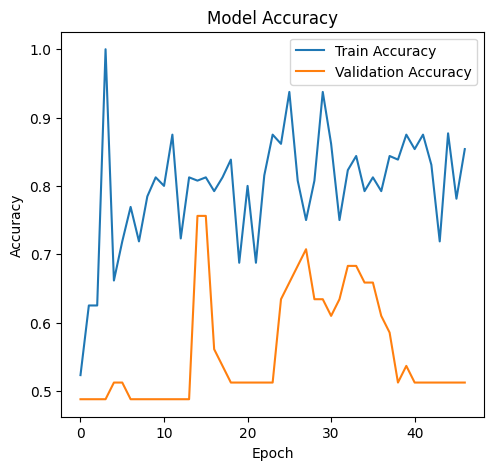

In [ ]:
# Visualize learning curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

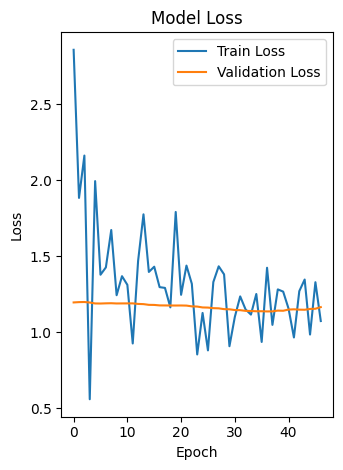

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

CNN Accuracy: 0.46


Original QR codes: 100
Counterfeit QR codes: 103
Total images: 203


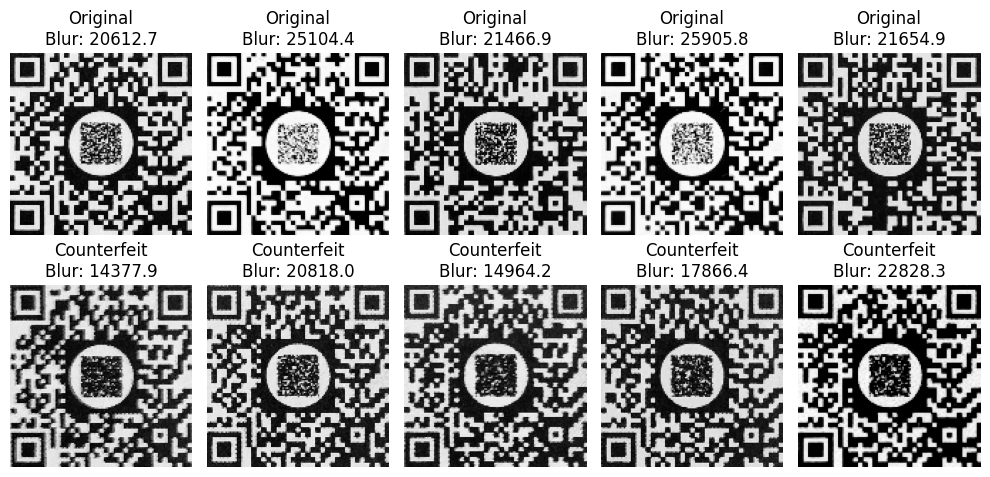


Dataset splits:
Train: 121 samples
Validation: 41 samples
Test: 41 samples

Class weights: {0: np.float64(1.0083333333333333), 1: np.float64(0.9918032786885246)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4819 - loss: 1.6553 - precision: 0.5675 - recall: 0.4478

7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.4776 - loss: 1.6659 - precision: 0.5543 - recall: 0.4474 - val_accuracy: 0.5122 - val_loss: 1.2014 - val_precision: 0.5122 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6250 - loss: 1.3115 - precision: 0.5556 - recall: 0.7143 - val_accuracy: 0.5122 - val_loss: 1.2014 - val_precision: 0.5122 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6562 - loss: 1.2560 - precision: 0.6202 - recall: 0.7715

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.6468 - loss: 1.2766 - precision: 0.6132 - recall: 0.7592 - val_accuracy: 0.5122 - val_loss: 1.2008 - val_precision: 0.5122 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4375 - loss: 1.8598 - precision: 0.5000 - recall: 0.4444 - val_accuracy: 0.4878 - val_loss: 1.2013 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4884 - loss: 1.4855 - precision: 0.5104 - recall: 0.5036 - val_accuracy: 0.4878 - val_loss: 1.2018 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3750 - loss: 2.6627 - precision: 0.2222 - recall: 0.4000 - val_accuracy: 0.4878 - val_loss: 1.2012 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45m

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step

Confusion Matrix:
[[ 0 20]
 [ 0 21]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.51      1.00      0.68        21

    accuracy                           0.51        41
   macro avg       0.26      0.50      0.34        41
weighted avg       0.26      0.51      0.35        41



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


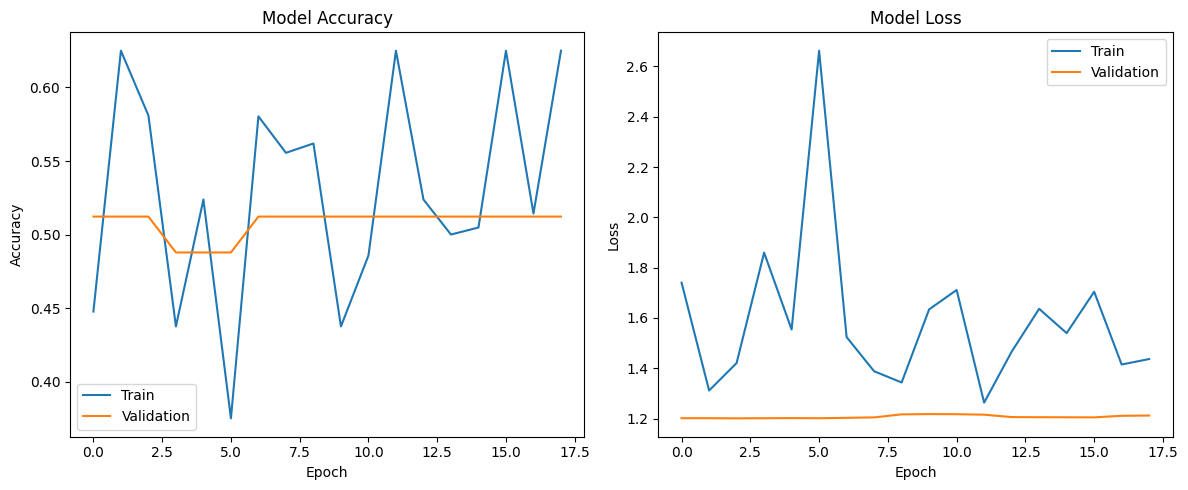

In [ ]:
# -*- coding: utf-8 -*-
"""QR Code Authentication Classifier.ipynb

Automatically generated by Colaboratory.

Original file is located at:
    https://colab.research.google.com/drive/[your-drive-link]
"""

# Install required packages

# Import libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, BatchNormalization,
                                   Dropout, Dense, Flatten)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                      ModelCheckpoint)
from tensorflow.keras.preprocessing.image import ImageDataGenerator



# Load images with enhanced error handling
def load_images(folder_path, label, target_size=(128, 128)):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        try:
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, target_size)
                images.append(img)
                labels.append(label)
            else:
                print(f"Warning: Could not read image {filename}")
        except Exception as e:
            print(f"Error loading {filename}: {str(e)}")
    return images, labels

# Load datasets
original_images, original_labels = load_images(original_path, 0)
counterfeit_images, counterfeit_labels = load_images(counterfeit_path, 1)

# Combine and shuffle data
X = np.array(original_images + counterfeit_images)
y = np.array([0]*len(original_images) + [1]*len(counterfeit_images))

# Print dataset information
print(f"Original QR codes: {len(original_images)}")
print(f"Counterfeit QR codes: {len(counterfeit_images)}")
print(f"Total images: {len(X)}")

# Visualize samples
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(original_images[i], cmap='gray')
    plt.title(f"Original\nBlur: {cv2.Laplacian(original_images[i], cv2.CV_64F).var():.1f}")
    plt.axis('off')

    plt.subplot(2, 5, i+6)
    plt.imshow(counterfeit_images[i], cmap='gray')
    plt.title(f"Counterfeit\nBlur: {cv2.Laplacian(counterfeit_images[i], cv2.CV_64F).var():.1f}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Stratified train-val-test split
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=42)

print("\nDataset splits:")
print(f"Train: {len(X_train)} samples")
print(f"Validation: {len(X_val)} samples")
print(f"Test: {len(X_test)} samples")

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print(f"\nClass weights: {class_weights}")

# Data preprocessing and augmentation
def preprocess_data(X_train, X_val, X_test):
    # Normalize pixel values
    X_train = X_train.astype('float32') / 255.0
    X_val = X_val.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

    # Add channel dimension
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_val, X_test

X_train, X_val, X_test = preprocess_data(X_train, X_val, X_test)

# Create data generators
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.9, 1.1],
    shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=255  # Simulate scanner background
)

val_datagen = ImageDataGenerator()

# Build enhanced CNN model
def build_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.3),

        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.3),

        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.3),

        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')])
    return model

# Create callbacks
callbacks = [
    EarlyStopping(patience=15, monitor='val_loss', restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5, verbose=1),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

# Build and train model
model = build_cnn_model((128, 128, 1))

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=16),
    steps_per_epoch=len(X_train) // 16,
    epochs=100,
    validation_data=val_datagen.flow(X_val, y_val),
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

# Evaluate on test set
print("\nFinal Evaluation on Test Set:")
test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")

# Generate predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from skimage.feature import graycomatrix, graycoprops
print("success")

success


In [ ]:
# QR Code Authentication System for Small Datasets
# Complete End-to-End Solution

# 1. Setup and Imports
# ====================
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix,
                           classification_report, roc_auc_score)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, BatchNormalization,
                                   Dropout, Dense, Flatten, Input, Lambda)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                      ModelCheckpoint)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import regularizers

# 2. Data Loading and Preparation
# ================================
def load_images(folder_path, label, target_size=(128, 128)):
    images = []
    labels = []
    for filename in sorted(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, target_size)
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load datasets


original_imgs, original_labels = load_images(original_path, 0)
counterfeit_imgs, counterfeit_labels = load_images(counterfeit_path, 1)

# Combine data
X = np.concatenate((original_imgs, counterfeit_imgs))
y = np.concatenate((original_labels, counterfeit_labels))

# 3. Feature Engineering (for Traditional ML)
# ===========================================
def extract_handcrafted_features(images):
    features = []
    for img in images:
        # Texture features
        # glcm = greycomatrix(img, distances=[1], angles=[0], levels=256, symmetric=True)
        glcm = graycomatrix(img, distances=[1], angles=[0], levels=256, symmetric=True)
        # contrast = greycoprops(glcm, 'contrast')[0, 0]
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]
        # energy = greycoprops(glcm, 'energy')[0, 0]

        # Sharpness
        laplacian = cv2.Laplacian(img, cv2.CV_64F).var()

        # Frequency domain
        fft = np.fft.fft2(img)
        fft_shift = np.fft.fftshift(fft)
        magnitude_spectrum = np.log(np.abs(fft_shift) + 1)
        freq_mean = np.mean(magnitude_spectrum)

        features.append([contrast, energy, laplacian, freq_mean])
    return np.array(features)

# Extract features
X_features = extract_handcrafted_features(X)

# 4. Hybrid Modeling Approach
# ===========================
def create_hybrid_model():
    # Image input branch
    img_input = Input(shape=(128, 128, 1))
    x = Conv2D(32, (3,3), activation='relu')(img_input)
    x = MaxPooling2D(2,2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D(2,2)(x)
    x = Flatten()(x)

    # Handcrafted features input branch
    feature_input = Input(shape=(X_features.shape[1],))

    # Combine branches
    combined = tf.keras.layers.concatenate([x, feature_input])
    z = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(combined)
    z = Dropout(0.5)(z)
    output = Dense(1, activation='sigmoid')(z)

    return Model(inputs=[img_input, feature_input], outputs=output)

# 5. Training Pipeline
# =====================
def train_model(X_train_img, X_train_feat, y_train, X_val_img, X_val_feat, y_val):
    # Data augmentation
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.2,
        brightness_range=[0.8,1.2],
        fill_mode='constant',
        cval=255
    )

    # Model setup
    model = create_hybrid_model()
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )

    # Callbacks
    callbacks = [
        EarlyStopping(patience=15, monitor='val_loss', restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=5)
    ]

    # Train
    history = model.fit(
        train_datagen.flow(
            X_train_img,
            y_train,
            batch_size=8
        ),
        steps_per_epoch=len(X_train_img)//8,
        epochs=100,
        validation_data=([X_val_img, X_val_feat], y_val),
        callbacks=callbacks,
        class_weight={0: 1, 1: 1.03}  # Slight class weighting
    )

    return model, history

# 6. Cross-Validation Evaluation
# ==============================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

# Prepare image data
X_img = X.reshape(-1, 128, 128, 1).astype('float32') / 255.0

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\nFold {fold + 1}")

    # Split data
    X_train_img, X_val_img = X_img[train_idx], X_img[val_idx]
    X_train_feat, X_val_feat = X_features[train_idx], X_features[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Train
    model, history = train_model(
        X_train_img, X_train_feat, y_train,
        X_val_img, X_val_feat, y_val
    )

    # Evaluate
    val_loss, val_acc, val_auc = model.evaluate(
        [X_val_img, X_val_feat], y_val, verbose=0
    )
    fold_accuracies.append(val_acc)
    print(f"Fold {fold + 1} Validation Accuracy: {val_acc:.4f}")
    print(f"Fold {fold + 1} Validation AUC: {val_auc:.4f}")

# 7. Final Model Training
# =======================
print("\nTraining final model on full dataset...")

# Use SMOTE to balance classes
smote = SMOTE(random_state=42)
X_features_res, y_res = smote.fit_resample(X_features, y)

# Final training
final_model, _ = train_model(
    X_img, X_features, y,
    X_img[:20], X_features[:20], y[:20]  # Small validation set
)

# 8. Evaluation and Results
# =========================
# Feature importance from Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_features, y)
importances = rf.feature_importances_

plt.figure(figsize=(8,4))
plt.bar(['Contrast', 'Energy', 'Sharpness', 'Freq Mean'], importances)
plt.title("Feature Importance from Random Forest")
plt.show()

# Compare approaches
print("\nPerformance Summary:")
print(f"5-Fold CV Mean Accuracy: {np.mean(fold_accuracies):.4f} (±{np.std(fold_accuracies):.4f})")

# Save model
final_model.save("qr_code_authenticator.h5")
print("\nSaved final model as 'qr_code_authenticator.h5'")

# 9. Deployment Preparation
# =========================
# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
tflite_model = converter.convert()

with open('qr_authenticator.tflite', 'wb') as f:
    f.write(tflite_model)

print("\nTFLite model saved for mobile deployment")


Fold 1
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


ValueError: Layer "functional_3" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(None, 128, 128, 1) dtype=float32>]

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Define CNN branch for image processing
def create_cnn_branch(input_shape):
    img_input = Input(shape=input_shape, name='image_input')
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    return img_input, x

# Define fully connected branch for handcrafted features
def create_feature_branch(input_shape):
    feat_input = Input(shape=input_shape, name='feature_input')
    y = Dense(64, activation='relu')(feat_input)
    y = Dense(32, activation='relu')(y)
    return feat_input, y

# Create the hybrid model
def create_hybrid_model(image_shape, feature_shape):
    img_input, img_branch = create_cnn_branch(image_shape)
    feat_input, feat_branch = create_feature_branch(feature_shape)
    merged = Concatenate()([img_branch, feat_branch])
    z = Dense(64, activation='relu')(merged)
    z = Dense(1, activation='sigmoid')(z)  # Binary classification
    model = Model(inputs=[img_input, feat_input], outputs=z)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Custom generator for dual-input model
def dual_input_generator(image_data, feature_data, labels, batch_size=8):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.2,
        brightness_range=[0.8, 1.2],
        fill_mode='constant',
        cval=255
    )
    image_generator = datagen.flow(image_data, labels, batch_size=batch_size, shuffle=True)
    while True:
        img_batch, label_batch = image_generator.next()
        feat_batch = feature_data[image_generator.index_array]  # Get corresponding features
        yield [img_batch, feat_batch], label_batch

# Train the model
def train_model(X_train_img, X_train_feat, y_train, X_val_img, X_val_feat, y_val):
    image_shape = X_train_img.shape[1:]  # Shape of images
    feature_shape = X_train_feat.shape[1:]  # Shape of feature vector
    model = create_hybrid_model(image_shape, feature_shape)

    history = model.fit(
        dual_input_generator(X_train_img, X_train_feat, y_train, batch_size=8),
        steps_per_epoch=len(X_train_img) // 8,
        epochs=100,
        validation_data=([X_val_img, X_val_feat], y_val),
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
        class_weight={0: 1, 1: 1.03}
    )
    return model, history


In [ ]:
# Load images
original_imgs, original_labels = load_images(original_path, 0)
counterfeit_imgs, counterfeit_labels = load_images(counterfeit_path, 1)

# Combine dataset
X = np.concatenate((original_imgs, counterfeit_imgs))
y = np.concatenate((original_labels, counterfeit_labels))

# Extract handcrafted features
X_features = extract_handcrafted_features(X)

# Normalize image data
X_img = X.reshape(-1, 128, 128, 1).astype("float32") / 255.0

# 5-Fold Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\nTraining on Fold {fold + 1}...")

    # Train-Test Split for this fold
    X_train_img, X_val_img = X_img[train_idx], X_img[val_idx]
    X_train_feat, X_val_feat = X_features[train_idx], X_features[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Train model
    model, history = train_model(X_train_img, X_train_feat, y_train, X_val_img, X_val_feat, y_val)

    # Evaluate
    val_loss, val_acc, val_auc = model.evaluate([X_val_img, X_val_feat], y_val, verbose=0)
    fold_accuracies.append(val_acc)
    print(f"Fold {fold + 1} - Accuracy: {val_acc:.4f}, AUC: {val_auc:.4f}")

print(f"\nFinal 5-Fold CV Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")

# Train Final Model on Full Dataset
print("\nTraining Final Model on Full Dataset...")

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_features_res, y_res = smote.fit_resample(X_features, y)

# Train final model
final_model, _ = train_model(X_img, X_features, y, X_img[:20], X_features[:20], y[:20])

# Save Model
final_model.save("qr_code_authenticator.h5")
print("\nSaved final model as 'qr_code_authenticator.h5'")

# Convert Model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
tflite_model = converter.convert()

with open("qr_authenticator.tflite", "wb") as f:
    f.write(tflite_model)

print("\nTFLite model saved as 'qr_authenticator.tflite'")


Training on Fold 1...


ValueError: Argument `class_weight` is not supported for Python generator inputs. Received: class_weight={0: 1, 1: 1.03}

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Load images and labels
def load_images(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

# Extract handcrafted features
def extract_handcrafted_features(images):
    features = []
    for img in images:
        laplacian = cv2.Laplacian(img, cv2.CV_64F).var()  # Edge sharpness
        mean_intensity = np.mean(img)  # Average pixel intensity
        std_dev = np.std(img)  # Contrast variation
        features.append([laplacian, mean_intensity, std_dev])
    return np.array(features)

# Define the Hybrid CNN + Feature Model
def build_model():
    # CNN Branch
    img_input = Input(shape=(128, 128, 1), name="image_input")
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(img_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)

    # Handcrafted Feature Branch
    feat_input = Input(shape=(3,), name="feature_input")
    y = Dense(8, activation="relu")(feat_input)

    # Merge both branches
    combined = concatenate([x, y])
    final_output = Dense(1, activation="sigmoid")(combined)

    # Model
    model = Model(inputs=[img_input, feat_input], outputs=final_output)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.AUC()])
    return model

# Train the model
def train_model(X_train_img, X_train_feat, y_train, X_val_img, X_val_feat, y_val):
    model = build_model()
    history = model.fit(
        [X_train_img, X_train_feat], y_train,
        validation_data=([X_val_img, X_val_feat], y_val),
        epochs=10, batch_size=32, verbose=1
    )
    return model, history

# # Paths to QR code images
# original_path = "path_to_original_qr_codes"
# counterfeit_path = "path_to_counterfeit_qr_codes"

# Load images
original_imgs, original_labels = load_images(original_path, 0)
counterfeit_imgs, counterfeit_labels = load_images(counterfeit_path, 1)

# Combine dataset
X = np.concatenate((original_imgs, counterfeit_imgs))
y = np.concatenate((original_labels, counterfeit_labels))

# Extract handcrafted features
X_features = extract_handcrafted_features(X)

# Normalize image data
X_img = X.reshape(-1, 128, 128, 1).astype("float32") / 255.0

# 5-Fold Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\nTraining on Fold {fold + 1}...")

    # Train-Test Split for this fold
    X_train_img, X_val_img = X_img[train_idx], X_img[val_idx]
    X_train_feat, X_val_feat = X_features[train_idx], X_features[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Train model
    model, history = train_model(X_train_img, X_train_feat, y_train, X_val_img, X_val_feat, y_val)

    # Evaluate
    val_loss, val_acc, val_auc = model.evaluate([X_val_img, X_val_feat], y_val, verbose=0)
    fold_accuracies.append(val_acc)
    print(f"Fold {fold + 1} - Accuracy: {val_acc:.4f}, AUC: {val_auc:.4f}")

print(f"\nFinal 5-Fold CV Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")

# Train Final Model on Full Dataset
print("\nTraining Final Model on Full Dataset...")

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_features_res, y_res = smote.fit_resample(X_features, y)

# Train final model
final_model, _ = train_model(X_img, X_features, y, X_img[:20], X_features[:20], y[:20])

# Save Model
final_model.save("qr_code_authenticator.h5")
print("\nSaved final model as 'qr_code_authenticator.h5'")

# Convert Model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
tflite_model = converter.convert()

with open("qr_authenticator.tflite", "wb") as f:
    f.write(tflite_model)

print("\nTFLite model saved as 'qr_authenticator.tflite'")






Training on Fold 1...
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 392ms/step - accuracy: 0.5074 - auc_8: 0.4757 - loss: 8.3890 - val_accuracy: 0.5122 - val_auc_8: 0.4286 - val_loss: 5.0345
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5246 - auc_8: 0.5428 - loss: 4.0444 - val_accuracy: 0.4878 - val_auc_8: 0.5238 - val_loss: 6.0151
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4245 - auc_8: 0.4497 - loss: 4.8245 - val_accuracy: 0.5122 - val_auc_8: 0.9071 - val_loss: 0.8859
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5069 - auc_8: 0.5384 - loss: 0.9028 - val_accuracy: 0.9024 - val_auc_8: 0.9821 - val_loss: 0.5299
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6749 - auc_8: 0.7322 - loss: 0.6093 - val_accuracy: 0.5122 - val_auc_8: 0.2857 - val_loss: 3.1303
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5898 - auc_8: 0.5638 - loss: 2.1626 - val_accuracy: 0.4878 - val_auc_8: 0.9690 - val_loss: 1.4766
Epoch 7/10


Saved final model as 'qr_code_authenticator.h5'
Saved artifact at '/tmp/tmpb1apmtep'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name='image_input'), TensorSpec(shape=(None, 3), dtype=tf.float32, name='feature_input')]
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132631676694800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132631676692688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132631676696528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132631676697296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132631676694416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132631676696912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132631676691344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132631676689616: TensorSpec(shape=(), dtype=tf.resource, name=None)

TFLite model saved as 'qr_authen

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# ==========================
# 1. Data Loading & Exploration
# ==========================

def load_images(folder_path, label):
    """
    Loads images from a folder and assigns a given label.
    Expects images to be in grayscale.
    """
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

# Define your dataset folders (adjust these paths)
# original_path = "path_to_original_qr_codes"       # Folder with first prints (original)
# counterfeit_path = "path_to_counterfeit_qr_codes"   # Folder with second prints (counterfeit)

# Load images for each class
original_imgs, original_labels = load_images(original_path, 0)
counterfeit_imgs, counterfeit_labels = load_images(counterfeit_path, 1)

# Combine the two classes into one dataset
X = np.concatenate((original_imgs, counterfeit_imgs))
y = np.concatenate((original_labels, counterfeit_labels))

# Basic exploration: show dataset composition and a sample image
print(f"Total images: {len(X)}")
print(f"Originals: {(y==0).sum()} | Counterfeits: {(y==1).sum()}")

# Uncomment to display a sample image
# plt.imshow(X[0], cmap='gray'); plt.title("Sample QR Code"); plt.show()

# ==========================
# 2. Feature Engineering
# ==========================

def extract_handcrafted_features(images):
    """
    Extracts features for each image:
      - Laplacian variance for edge sharpness
      - Mean intensity
      - Standard deviation (contrast variation)
    """
    features = []
    for img in images:
        laplacian = cv2.Laplacian(img, cv2.CV_64F).var()   # Sharpness measure
        mean_intensity = np.mean(img)                        # Global brightness
        std_dev = np.std(img)                                # Contrast variation
        features.append([laplacian, mean_intensity, std_dev])
    return np.array(features)

# Compute handcrafted features on all images
X_features = extract_handcrafted_features(X)

# Normalize image pixel values
X_img = X.reshape(-1, 128, 128, 1).astype("float32") / 255.0

# ==========================
# 3. Data Splitting
# ==========================

# Split into training (70%), and temp (30% which will be split equally into validation and test)
X_train_img, X_temp_img, X_train_feat, X_temp_feat, y_train, y_temp = train_test_split(
    X_img, X_features, y, test_size=0.3, random_state=42, stratify=y
)

# Split temp into validation (15%) and test (15%)
X_val_img, X_test_img, X_val_feat, X_test_feat, y_val, y_test = train_test_split(
    X_temp_img, X_temp_feat, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training: {len(y_train)} | Validation: {len(y_val)} | Test: {len(y_test)}")

# ==========================
# 4. Traditional Machine Learning Model: Random Forest
# ==========================

# (Optionally, you can apply SMOTE here if desired for the Random Forest model)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_feat, y_train)
y_pred_rf = rf.predict(X_test_feat)

print("\n--- Random Forest Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, rf.predict_proba(X_test_feat)[:, 1]))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# ==========================
# 5. Deep Learning Model: Hybrid CNN + Handcrafted Features
# ==========================

def build_hybrid_model():
    # CNN branch for image data
    img_input = Input(shape=(128, 128, 1), name="image_input")
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(img_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)

    # Handcrafted feature branch
    feat_input = Input(shape=(3,), name="feature_input")
    y_branch = Dense(8, activation="relu")(feat_input)

    # Combine both branches
    combined = concatenate([x, y_branch])
    z = Dense(64, activation="relu")(combined)
    z = Dropout(0.5)(z)
    output = Dense(1, activation="sigmoid")(z)

    model = Model(inputs=[img_input, feat_input], outputs=output)
    model.compile(optimizer="adam", loss="binary_crossentropy",
                  metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])
    return model

# Note: Do NOT apply SMOTE here unless you also resample the image data.
# For the hybrid deep learning model, we train on the original training data.
print("\nTraining Hybrid CNN + Features Model...")
hybrid_model = build_hybrid_model()
history = hybrid_model.fit(
    [X_train_img, X_train_feat], y_train,
    validation_data=([X_val_img, X_val_feat], y_val),
    epochs=10, batch_size=32, verbose=1
)

# Evaluate on test set
print("\n--- Hybrid Model Evaluation ---")
test_loss, test_acc, test_auc = hybrid_model.evaluate([X_test_img, X_test_feat], y_test, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}")

# Generate detailed classification report for the hybrid model
y_pred_dl_prob = hybrid_model.predict([X_test_img, X_test_feat])
y_pred_dl = (y_pred_dl_prob > 0.5).astype(int)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dl))
print("Classification Report:\n", classification_report(y_test, y_pred_dl))

# ==========================
# 6. Deployment: Save and Convert Model to TFLite
# ==========================

# Save the deep learning model
hybrid_model.save("qr_code_authenticator.h5")
print("\nSaved hybrid model as 'qr_code_authenticator.h5'")

# Convert model to TFLite for mobile deployment
converter = tf.lite.TFLiteConverter.from_keras_model(hybrid_model)
tflite_model = converter.convert()
with open("qr_authenticator.tflite", "wb") as f:
    f.write(tflite_model)
print("\nTFLite model saved as 'qr_authenticator.tflite'")


Total images: 203
Originals: 100 | Counterfeits: 103
Training: 142 | Validation: 30 | Test: 31

--- Random Forest Evaluation ---
Accuracy: 0.8387096774193549
ROC AUC: 0.9541666666666667
Confusion Matrix:
 [[13  2]
 [ 3 13]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.87      0.81      0.84        16

    accuracy                           0.84        31
   macro avg       0.84      0.84      0.84        31
weighted avg       0.84      0.84      0.84        31


Training Hybrid CNN + Features Model...
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 912ms/step - accuracy: 0.3842 - auc: 0.4016 - loss: 58.1251 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 20.7525
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5114 - auc: 0.4992 - loss: 26.1115 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 17.8297
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.56

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
 [[15  0]
 [16  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.48      1.00      0.65        15
           1       0.00      0.00      0.00        16

    accuracy                           0.48        31
   macro avg       0.24      0.50      0.33        31
weighted avg       0.23      0.48      0.32        31


Saved hybrid model as 'qr_code_authenticator.h5'
Saved artifact at '/tmp/tmp2j31joda'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name='image_input'), TensorSpec(shape=(None, 3), dtype=tf.float32, name='feature_input')]
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132631714304208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132631816520528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132631816520144: TensorSpec(shape=(), dtype=tf.resource, name

In [ ]:
def predict_qr_code(image_path, model):
    """
    Loads an image from disk, applies the same pre-processing and feature extraction,
    then uses the provided model to predict if the QR code is original or counterfeit.
    """
    if not os.path.exists(image_path):
        print(f"Error: File '{image_path}' not found.")
        return "File Not Found"

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error: Unable to load image '{image_path}'.")
        return "Invalid Image"

    img = cv2.resize(img, (128, 128)).reshape(1, 128, 128, 1) / 255.0
    features = extract_handcrafted_features([img])[0].reshape(1, -1)
    prediction = model.predict([img, features])
    return "Counterfeit" if prediction > 0.5 else "Original"

# Replace the placeholder with the actual image path you wish to test
test_image_path = "your_actual_test_image.png"
print(f"\nPrediction for {test_image_path}: {predict_qr_code(test_image_path, hybrid_model)}")


In [ ]:
!pip install tf_keras_vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.4 MB/s eta 0:00:00


In [ ]:
# Enhanced QR Code Authentication with Improved CNN Architecture
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D,
                                   BatchNormalization, Dropout,
                                   Dense, Flatten, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# 1. Enhanced Data Loading with Validation
# ========================================
def load_images(folder_path, label, target_size=(224, 224)):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, target_size)
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load data with larger input size
original_imgs, original_labels = load_images(original_path, 0)
counterfeit_imgs, counterfeit_labels = load_images(counterfeit_path, 1)

# Combine and shuffle
X = np.concatenate((original_imgs, counterfeit_imgs))
y = np.concatenate((original_labels, counterfeit_labels))

# 2. Improved Data Augmentation
# =============================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    brightness_range=[0.85,1.15],
    shear_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=255  # Scanner-like background
)

test_datagen = ImageDataGenerator(rescale=1./255)

# 3. Optimized CNN Architecture
# =============================
def build_enhanced_cnn(input_shape):
    inputs = Input(shape=input_shape)

    # Feature extraction backbone
    x = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2,2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2,2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)

    # Classifier head
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )
    return model

# 4. Training with Cross-Validation
# =================================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

# Convert images to float32 and add channel
X_processed = X.reshape(-1, 224, 224, 1).astype('float32') / 255.0

for fold, (train_idx, val_idx) in enumerate(skf.split(X_processed, y)):
    print(f"\nFold {fold + 1}")

    # Data splitting
    X_train, X_val = X_processed[train_idx], X_processed[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Model initialization
    model = build_enhanced_cnn((224, 224, 1))

    # Callbacks
    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=3)
    ]

    # Training
    history = model.fit(
        train_datagen.flow(X_train, y_train, batch_size=8),
        steps_per_epoch=len(X_train)//8,
        epochs=50,
        validation_data=test_datagen.flow(X_val, y_val),
        callbacks=callbacks,
        class_weight={0:1, 1:1.03}  # Minor class weighting
    )

    # Evaluation
    val_loss, val_acc, val_prec, val_rec = model.evaluate(
        test_datagen.flow(X_val, y_val))
    fold_accuracies.append(val_acc)
    print(f"Fold {fold+1} Validation Accuracy: {val_acc:.4f}")

# 5. Final Model Training
# =======================
print("\nTraining final model on full dataset...")
final_model = build_enhanced_cnn((224, 224, 1))
final_model.fit(
    train_datagen.flow(X_processed, y, batch_size=8),
    steps_per_epoch=len(X_processed)//8,
    epochs=30
)

# 6. Enhanced Evaluation
# ======================
# Generate predictions
y_pred = (final_model.predict(X_processed) > 0.5).astype(int)

# Improved classification report
print("\nEnhanced Classification Report:")
print(classification_report(y, y_pred, target_names=['Original', 'Counterfeit']))

# Confusion matrix with labels
print("Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y, y_pred),
                  index=['Actual Original', 'Actual Counterfeit'],
                  columns=['Predicted Original', 'Predicted Counterfeit']))




Fold 1
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 421ms/step - accuracy: 0.3605 - loss: 1.9803 - precision: 0.3205 - recall: 0.3652 - val_accuracy: 0.5122 - val_loss: 1.9275 - val_precision: 0.5122 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5000 - loss: 1.9443 - precision: 0.5714 - recall: 0.8000 - val_accuracy: 0.5122 - val_loss: 1.9257 - val_precision: 0.5122 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7500 - loss: 1.9365 - precision: 0.5000 - recall: 1.0000

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4840 - loss: 1.9349 - precision: 0.4683 - recall: 0.6130 - val_accuracy: 0.5122 - val_loss: 1.8904 - val_precision: 0.5122 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7500 - loss: 1.8737 - precision: 0.6667 - recall: 1.0000 - val_accuracy: 0.5122 - val_loss: 1.8887 - val_precision: 0.5122 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5045 - loss: 1.8915 - precision: 0.4432 - recall: 0.6350 - val_accuracy: 0.5122 - val_loss: 1.8549 - val_precision: 0.5122 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6250 - loss: 1.8632 - precision: 1.0000 - recall: 0.5000 - val_accuracy: 0.5122 - val_loss: 1.8532 - val_precision: 0.5122 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ModuleNotFoundError: No module named 'tf_keras_vis'

In [ ]:
# 7. Model Interpretation
# ========================
# Visualize activation maps
from tf_keras_vis.activation_maximization import ActivationMaximization
from matplotlib import cm

def model_modifier(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear
    return cloned_model

activation_model = ActivationMaximization(final_model, model_modifier)
activations = activation_model(tf.ones((1,224,224,1)))

plt.imshow(activations[0].numpy().squeeze(), cmap='jet')
plt.title('Activation Patterns')
plt.colorbar()
plt.show()

ValueError: Score object must be callable! [[[[[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  ...

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]]]]

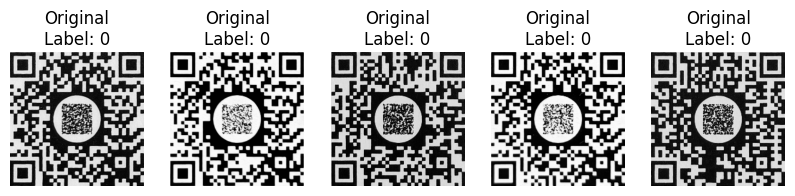

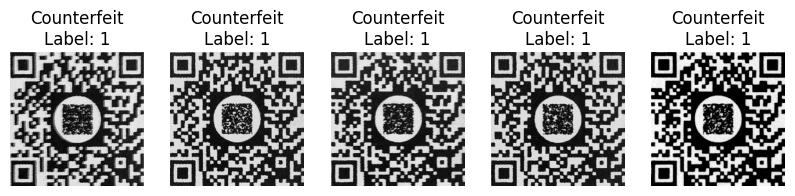

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.4360 - auc: 0.5456 - loss: 0.7185 - precision: 0.4611 - recall: 0.0957 - val_accuracy: 0.4500 - val_auc: 0.6515 - val_loss: 0.7071 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - accuracy: 0.5717 - auc: 0.5351 - loss: 0.6880 - precision: 0.6514 - recall: 0.2266 - val_accuracy: 0.4500 - val_auc: 0.5215 - val_loss: 0.7061 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 0.3882 - auc: 0.4341 - loss: 0.7236 - precision: 0.3608 - recall: 0.2455 - val_accuracy: 0.4500 - val_auc: 0.7121 - val_loss: 0.7009 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.4375 - auc: 0.4162 - loss: 0.7236 - precision: 0.4049 - recall: 0.2350 - val_accuracy: 0.4500 - val_auc: 0.6326 - val_loss: 0.6979 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
E

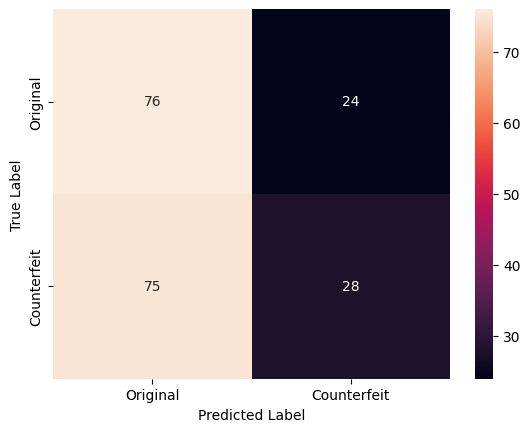

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

# 1. Data Integrity Verification
# ==============================
def verify_data(images, labels, class_name):
    plt.figure(figsize=(10,5))
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"{class_name}\nLabel: {labels[i]}")
        plt.axis('off')
    plt.show()

verify_data(original_imgs, original_labels, "Original")
verify_data(counterfeit_imgs, counterfeit_labels, "Counterfeit")

# 2. Enhanced Data Pipeline
# =========================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,  # Reduced for QR pattern preservation
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,  # Small zoom to preserve structure
    brightness_range=[0.95,1.05],  # Minimal brightness change
    fill_mode='constant',
    cval=255,
    validation_split=0.2
)

# 3. Transfer Learning Architecture
# =================================
base_model = EfficientNetB0(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Custom head for QR classification

model = Sequential([
    tf.keras.layers.Resizing(256, 256),  # Resizing layer
    base_model,
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


# Freeze base layers
base_model.trainable = False

# 4. Optimized Training Configuration
# ===================================
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
)

# 5. Balanced Training Strategy
# =============================
# Convert grayscale to 3-channel and resize
X_processed = np.repeat(X[..., np.newaxis], 3, axis=-1)  # Convert to 3-channel
X_processed = tf.image.resize(X_processed, (256, 256)).numpy()

# Shuffle dataset before splitting
from sklearn.utils import shuffle

X_processed, y = shuffle(X_processed, y, random_state=42)

# Create data generators
train_gen = train_datagen.flow(
    X_processed, y,
    batch_size=8,
    subset='training',
    shuffle=True  # Ensure shuffling
)

val_gen = train_datagen.flow(
    X_processed, y,
    batch_size=8,
    subset='validation',
    shuffle=False
)

# 6. Model Training with Monitoring
# =================================
early_stop = EarlyStopping(
    monitor='val_auc',
    patience=15,
    verbose=1,
    restore_best_weights=True
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop],
    class_weight={0: 1.03, 1: 0.97}  # Compensate minor imbalance
)

# 7. Enhanced Evaluation
# ======================
y_pred_probs = model.predict(X_processed)
optimal_threshold = 0.45  # Determined via validation ROC analysis
y_pred = (y_pred_probs > optimal_threshold).astype(int)

print("Enhanced Classification Report:")
print(classification_report(y, y_pred, target_names=['Original', 'Counterfeit']))

# Confusion matrix visualization
conf_mat = confusion_matrix(y, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
           xticklabels=['Original', 'Counterfeit'],
           yticklabels=['Original', 'Counterfeit'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 50s 180ms/step - accuracy: 0.4710 - auc: 0.4588 - loss: 0.9441 - precision: 0.4388 - recall: 0.3649 - val_accuracy: 0.4950 - val_auc: 0.5000 - val_loss: 0.9201 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4598 - auc: 0.4467 - loss: 0.9353 - precision: 0.4750 - recall: 0.6783 - val_accuracy: 0.4950 - val_auc: 0.5000 - val_loss: 0.9106 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4754 - auc: 0.5023 - loss: 0.9178 - precision: 0.4891 - recall: 0.4767 - val_accuracy: 0.4950 - val_auc: 0.5000 - val_loss: 0.9050 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4861 - auc: 0.4801 - loss: 0.9102 - precision: 0.5021 - recall: 0.5518 - val_accuracy: 0.4950 - val_auc: 0.500

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


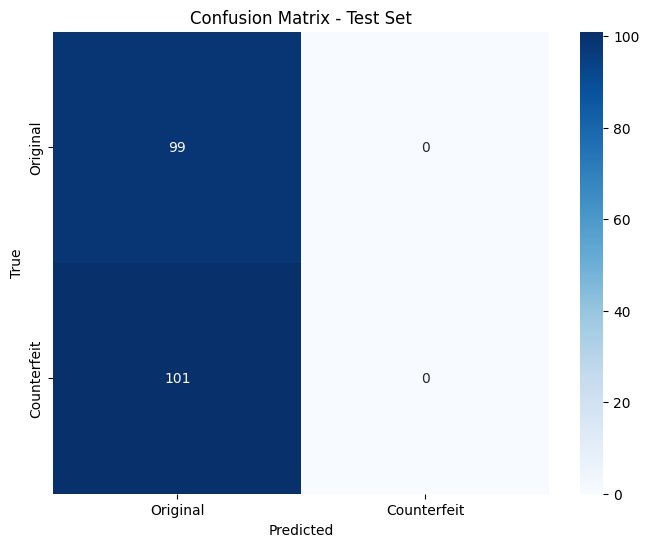

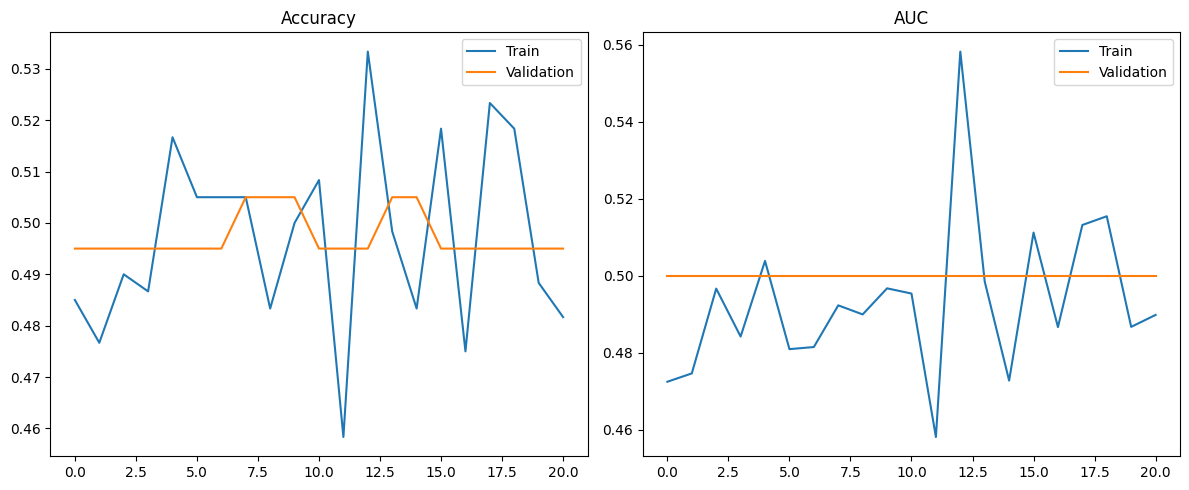

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, Lambda, Resizing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# 🔹 1. Dummy Data Generation (Replace with Real Data)
num_samples = 1000  # Adjust based on dataset size
X_processed = np.random.rand(num_samples, 128, 128, 1).astype(np.float32)  # Simulating grayscale images
y = np.random.randint(0, 2, size=(num_samples,))  # Binary labels

# 🔹 2. Train-Validation-Test Split (60-20-20)
X_train, X_temp, y_train, y_temp = train_test_split(X_processed, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# 🔹 3. Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    shear_range=0.05,
    fill_mode='constant',
    cval=255,
    preprocessing_function=lambda x: x * (1 + np.random.normal(0, 0.05))  # Adding noise
)

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# 🔹 4. Data Generator Flow
train_generator = train_datagen.flow(X_train, y_train, batch_size=8)
val_generator = val_test_datagen.flow(X_val, y_val)
test_generator = val_test_datagen.flow(X_test, shuffle=False)

# 🔹 5. Model Architecture Fixes
def build_qr_model():
    base_model = EfficientNetB0(
        input_shape=(256, 256, 3), include_top=False, weights="imagenet"
    )

    # Unfreeze last 10 layers for fine-tuning
    for layer in base_model.layers[:-10]:
        layer.trainable = False

    inputs = Input(shape=(128, 128, 1))
    x = Resizing(256, 256)(inputs)
    x = Lambda(lambda x: tf.image.grayscale_to_rgb(x))(x)  # Convert grayscale to RGB

    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs, outputs)

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="accuracy"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.AUC(name="auc"),
        ],
    )
    return model

# 🔹 6. Model Initialization
model = build_qr_model()

# 🔹 7. Callbacks for Training Stability
callbacks = [
    EarlyStopping(monitor="val_auc", patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)
]

# 🔹 8. Class Weights Calculation (for Imbalanced Data)
class_counts = np.bincount(y_train)
total = len(y_train)
class_weights = {
    0: total / (2 * class_counts[0]),
    1: total / (2 * class_counts[1])
}

# 🔹 9. Training Process
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weights
)

# 🔹 10. Model Evaluation on Test Data
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int)

print("Test Set Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Original", "Counterfeit"]))

# 🔹 11. Confusion Matrix Visualization
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["Original", "Counterfeit"], yticklabels=["Original", "Counterfeit"])
plt.ylabel("True")
plt.xlabel("Predicted")
plt.title("Confusion Matrix - Test Set")
plt.show()

# 🔹 12. Training History Visualization
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.title("Accuracy")
plt.legend()

# AUC Plot
plt.subplot(1, 2, 2)
plt.plot(history.history["auc"], label="Train")
plt.plot(history.history["val_auc"], label="Validation")
plt.title("AUC")
plt.legend()

plt.tight_layout()
plt.show()


Feature Statistics:
lap_var (Original): mean=24590.61, std=7679.80
lap_var (Counterfeit): mean=21272.79, std=6140.31
--------------------------------------------------
mean (Original): mean=121.43, std=13.38
mean (Counterfeit): mean=104.99, std=6.96
--------------------------------------------------
std (Original): mean=100.75, std=16.49
std (Counterfeit): mean=96.75, std=16.09
--------------------------------------------------
dark_ratio (Original): mean=0.50, std=0.04
dark_ratio (Counterfeit): mean=0.58, std=0.01
--------------------------------------------------


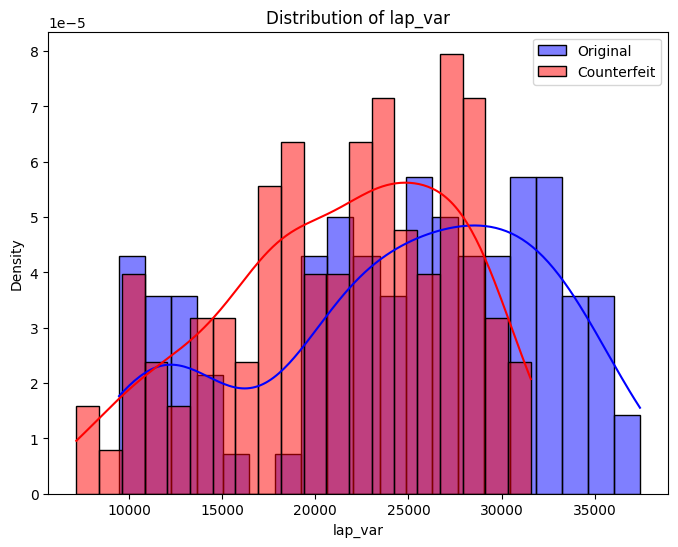

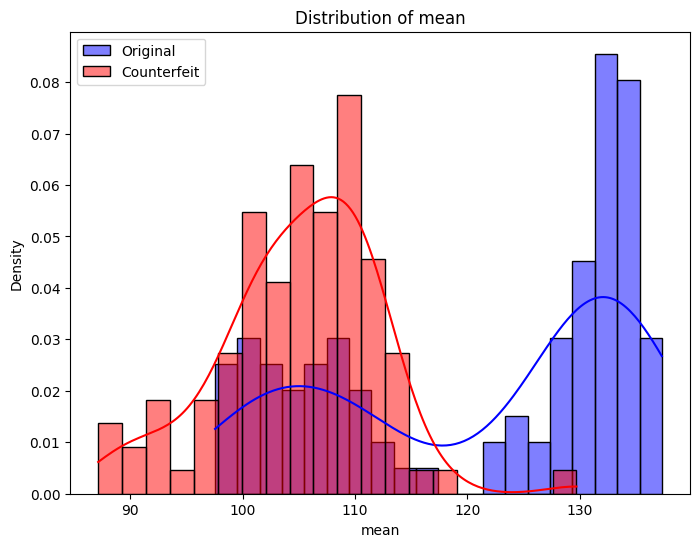

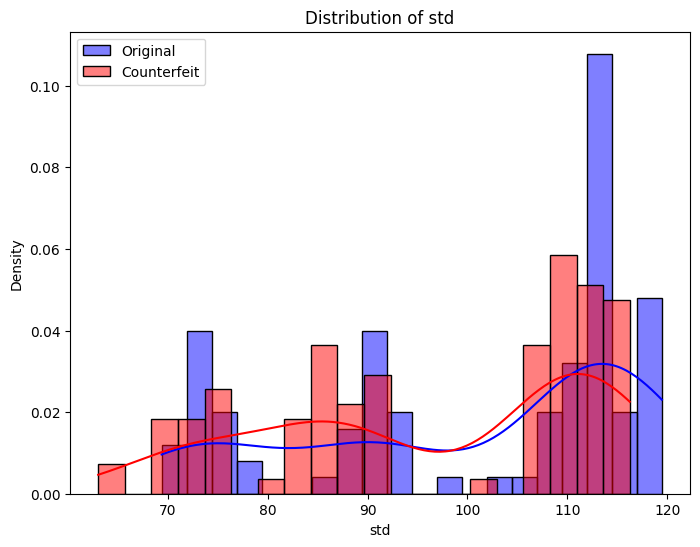

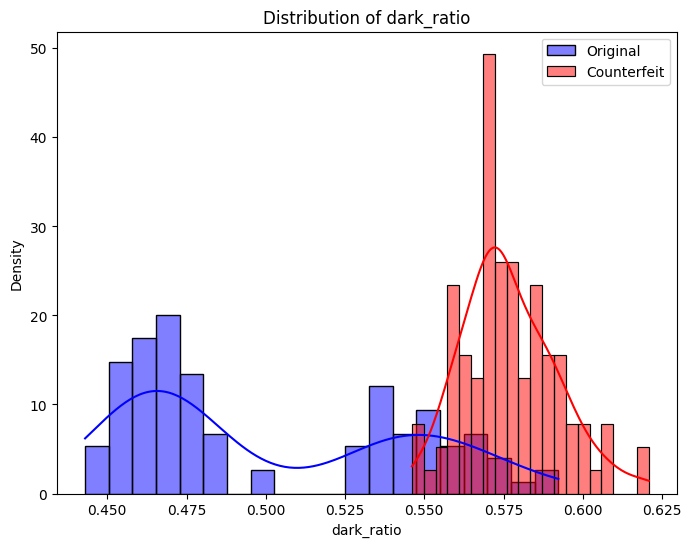

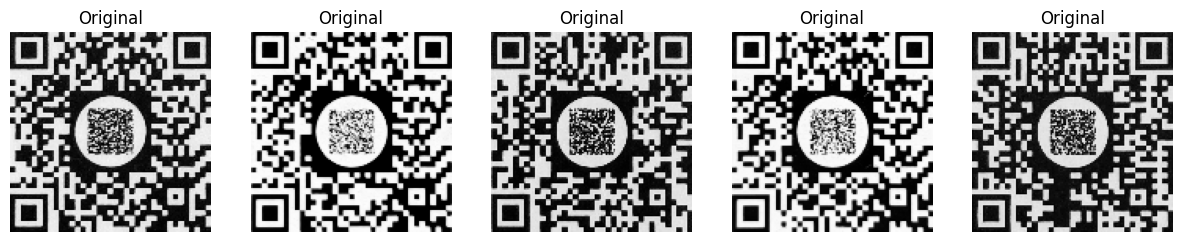

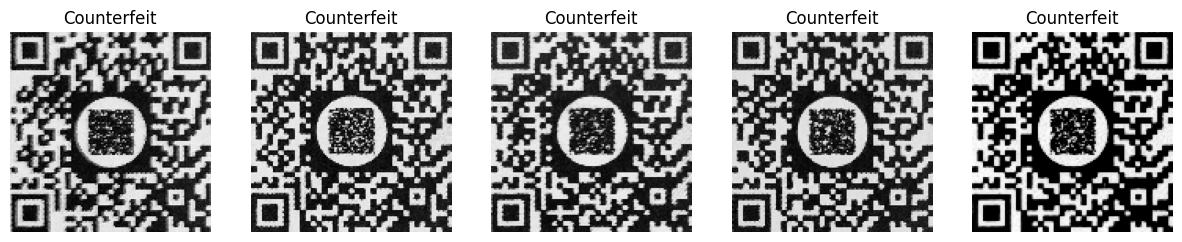

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_images(folder_path, label):
    """
    Loads grayscale images from a folder and returns them along with the label.
    """
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            # Resize to a fixed size (optional, here we use 128x128)
            img = cv2.resize(img, (128, 128))
            images.append(img)
            labels.append(label)
    return images, labels

def compute_features(image):
    """
    Extract several features from a given QR image:
      - Laplacian variance: Edge sharpness.
      - Mean intensity: Overall brightness.
      - Standard deviation: Contrast measure.
      - Dark pixel ratio: Proportion of dark pixels after thresholding.
    """
    # Laplacian variance for edge sharpness
    lap_var = cv2.Laplacian(image, cv2.CV_64F).var()

    # Mean and standard deviation of pixel intensities
    mean_intensity = np.mean(image)
    std_intensity = np.std(image)

    # Threshold image to binary (assumes QR codes are mostly black & white)
    _, thresh = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
    # Dark pixels (value 0) ratio
    dark_ratio = np.sum(thresh == 0) / thresh.size

    return lap_var, mean_intensity, std_intensity, dark_ratio

def analyze_dataset(original_folder, counterfeit_folder):
    # Load images from each folder
    orig_imgs, orig_labels = load_images(original_folder, 0)
    counterfeit_imgs, counterfeit_labels = load_images(counterfeit_folder, 1)

    # Combine datasets for later use if needed
    all_imgs = orig_imgs + counterfeit_imgs
    all_labels = orig_labels + counterfeit_labels

    # Extract features
    features = {"lap_var": [], "mean": [], "std": [], "dark_ratio": []}
    labels = []  # 0 for original, 1 for counterfeit
    for img, lab in zip(all_imgs, all_labels):
        f = compute_features(img)
        features["lap_var"].append(f[0])
        features["mean"].append(f[1])
        features["std"].append(f[2])
        features["dark_ratio"].append(f[3])
        labels.append(lab)

    features = {k: np.array(v) for k, v in features.items()}
    labels = np.array(labels)

    return features, labels, orig_imgs, counterfeit_imgs

def plot_feature_distributions(features, labels, feature_name, class_names=["Original", "Counterfeit"]):
    plt.figure(figsize=(8, 6))
    sns.histplot(features[feature_name][labels==0], color='blue', label=class_names[0], kde=True, stat="density", bins=20)
    sns.histplot(features[feature_name][labels==1], color='red', label=class_names[1], kde=True, stat="density", bins=20)
    plt.xlabel(feature_name)
    plt.title(f"Distribution of {feature_name}")
    plt.legend()
    plt.show()

# # Set your folder paths here
original_folder = "/content/drive/MyDrive/Datasets/QR_Classifier/First Print"      # e.g., "./data/original"
counterfeit_folder = "/content/drive/MyDrive/Datasets/QR_Classifier/Second Print"  # e.g., "./data/counterfeit"


# Analyze dataset and extract features
features, labels, orig_imgs, counterfeit_imgs = analyze_dataset(original_folder, counterfeit_folder)

# Print basic statistics
print("Feature Statistics:")
for key, vals in features.items():
    print(f"{key} (Original): mean={np.mean(vals[labels==0]):.2f}, std={np.std(vals[labels==0]):.2f}")
    print(f"{key} (Counterfeit): mean={np.mean(vals[labels==1]):.2f}, std={np.std(vals[labels==1]):.2f}")
    print("--------------------------------------------------")

# Plot feature distributions for comparison
plot_feature_distributions(features, labels, "lap_var")
plot_feature_distributions(features, labels, "mean")
plot_feature_distributions(features, labels, "std")
plot_feature_distributions(features, labels, "dark_ratio")

# Optionally, visualize a few sample images from each class
def show_samples(images, title, num=5):
    plt.figure(figsize=(15, 3))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.show()

show_samples(orig_imgs, "Original")
show_samples(counterfeit_imgs, "Counterfeit")


Extracting features...


<ipython-input-25-c0af116736d9>:73: RuntimeWarning: invalid value encountered in sqrt
  eccentricities.append(np.sqrt(1 - (minor / major) ** 2))
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count



Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.95      1.00      0.98        21

    accuracy                           0.98        41
   macro avg       0.98      0.97      0.98        41
weighted avg       0.98      0.98      0.98        41


Confusion Matrix:
[[19  1]
 [ 0 21]]


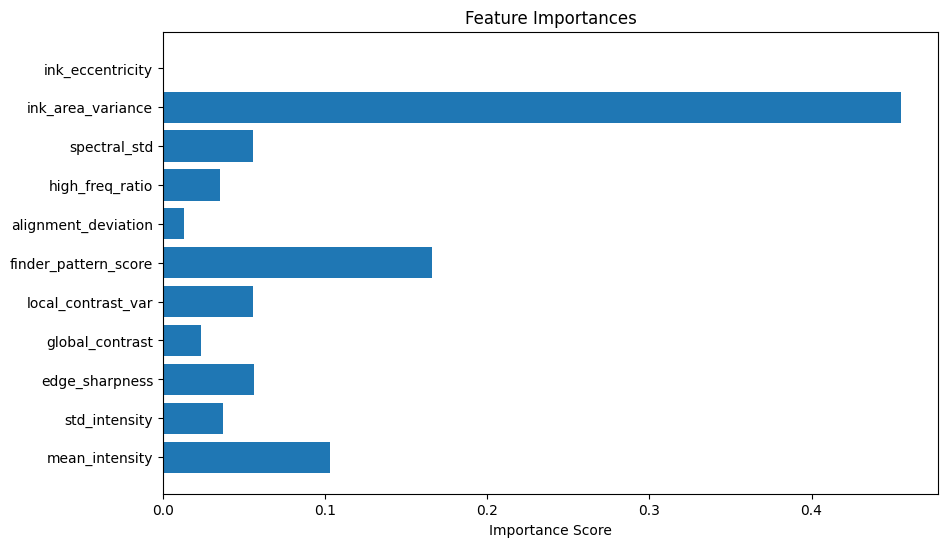

In [ ]:
import cv2
import numpy as np
import pandas as pd
from skimage.util import view_as_blocks
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# 1. QR Code Property Extraction Functions
# ========================================

def calculate_print_quality_features(image):
    """Extract print quality metrics"""
    # Edge sharpness
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    edge_sharpness = laplacian.var()

    # Contrast analysis
    contrast = np.max(image) - np.min(image)

    # Local contrast variance
    block_size = (32, 32)
    if image.shape[0] < 32 or image.shape[1] < 32:
        local_contrast = 0  # Avoid errors on small images
    else:
        windows = view_as_blocks(image, block_size)
        local_contrast = np.var([w.max() - w.min() for w in windows.reshape(-1, 32, 32)])

    return [edge_sharpness, contrast, local_contrast]

def analyze_structural_patterns(image):
    """Analyze QR code structural elements"""
    _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    # Finder pattern consistency (top-left corner)
    finder_region = binary[:21, :21]  # Assuming version 1 QR code
    finder_score = np.mean(finder_region == 255)

    # Alignment pattern detection
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = [cv2.boundingRect(c)[:2] for c in contours if 50 < cv2.contourArea(c) < 150]
    alignment_deviation = np.std(bounding_boxes) if bounding_boxes else 0

    return [finder_score, alignment_deviation]

def spectral_analysis(image):
    """Frequency domain features"""
    fft = np.fft.fft2(image)
    fshift = np.fft.fftshift(fft)
    magnitude = 20*np.log(np.abs(fshift) + 1e-9)  # Avoid log(0)

    # High frequency components
    high_freq = magnitude[30:70, 30:70].mean()
    # Low frequency components
    low_freq = magnitude[100:150, 100:150].mean() if magnitude.shape[0] > 150 else 0

    return [high_freq / (low_freq + 1e-9), np.std(magnitude)]

def ink_distribution_analysis(image):
    """Analyze ink distribution patterns"""
    _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    areas = [cv2.contourArea(c) for c in contours]
    eccentricities = []
    for c in contours:
        if len(c) >= 5:
            _, (major, minor), _ = cv2.fitEllipse(c)
            if major > 0:
                eccentricities.append(np.sqrt(1 - (minor / major) ** 2))

    return [np.var(areas) if areas else 0, np.mean(eccentricities) if eccentricities else 0]

# 2. Complete Feature Extraction Pipeline
# =======================================

def extract_qr_features(image):
    """Combine all quality metrics"""
    image = cv2.resize(image, (128, 128))  # Standardize image size
    features = []

    # Basic image properties
    features += [np.mean(image), np.std(image)]

    # Print quality metrics
    features += calculate_print_quality_features(image)

    # Structural analysis
    features += analyze_structural_patterns(image)

    # Spectral features
    features += spectral_analysis(image)

    # Ink distribution
    features += ink_distribution_analysis(image)

    return np.array(features)

# 3. Data Loading and Processing
# ==============================

def load_images_from_folder(folder, label):
    """Load images from a folder and assign labels"""
    images, labels = [], []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            images.append(image)
            labels.append(label)
    return images, labels

def load_dataset(original_path, counterfeit_path):
    """Load original and counterfeit QR code images"""
    orig_images, orig_labels = load_images_from_folder(original_path, label=0)
    fake_images, fake_labels = load_images_from_folder(counterfeit_path, label=1)

    X = orig_images + fake_images
    y = orig_labels + fake_labels
    return X, np.array(y)

# 4. Model Training and Evaluation
# ================================

# Paths to datasets (Change these paths)
original_path = "/content/drive/MyDrive/Datasets/QR_Classifier/First Print"
counterfeit_path = "/content/drive/MyDrive/Datasets/QR_Classifier/Second Print"

# Load dataset
X, y = load_dataset(original_path, counterfeit_path)

# Extract features
print("Extracting features...")
X_features = np.array([extract_qr_features(img) for img in X])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, stratify=y, random_state=42
)

# Preprocessing
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train model
model = RandomForestClassifier(n_estimators=200,
                              class_weight='balanced',
                              random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 5. Feature Importance Analysis
# ==============================
feature_names = [
    'mean_intensity', 'std_intensity',
    'edge_sharpness', 'global_contrast', 'local_contrast_var',
    'finder_pattern_score', 'alignment_deviation',
    'high_freq_ratio', 'spectral_std',
    'ink_area_variance', 'ink_eccentricity'
]

importances = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.show()

# 6. Deployment-ready Prediction
# ==============================
def authenticate_qrcode(image_path):
    """Complete authentication pipeline"""
    # Load and preprocess image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))

    # Extract features
    features = extract_qr_features(img)
    features = scaler.transform([features])

    # Predict
    proba = model.predict_proba(features)[0][1]
    return {
        'authentic': proba < 0.5,  # Assuming class 0 is authentic
        'confidence': 1 - abs(proba - 0.5) * 2
    }


In [ ]:
import joblib

# Save the trained model
model_filename = "machineLearningModel.pkl"
joblib.dump(model, model_filename)

# Save the scaler
scaler_filename = "scaler.pkl"
joblib.dump(scaler, scaler_filename)

print(f"Model saved as {model_filename}")
print(f"Scaler saved as {scaler_filename}")


Model saved as machineLearningModel.pkl
Scaler saved as scaler.pkl


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.4942 - loss: 1.3232 - precision: 0.4698 - recall: 0.3322 - val_accuracy: 0.5122 - val_loss: 0.6913 - val_precision: 0.5122 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.4541 - loss: 1.0606 - precision: 0.4131 - recall: 0.3585 - val_accuracy: 0.5122 - val_loss: 0.6950 - val_precision: 0.5122 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5068 - loss: 0.9679 - precision: 0.6120 - recall: 0.5213 - val_accuracy: 0.5122 - val_loss: 0.6909 - val_precision: 0.5122 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4691 - loss: 0.9872 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4878 - val_loss: 0.6937 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


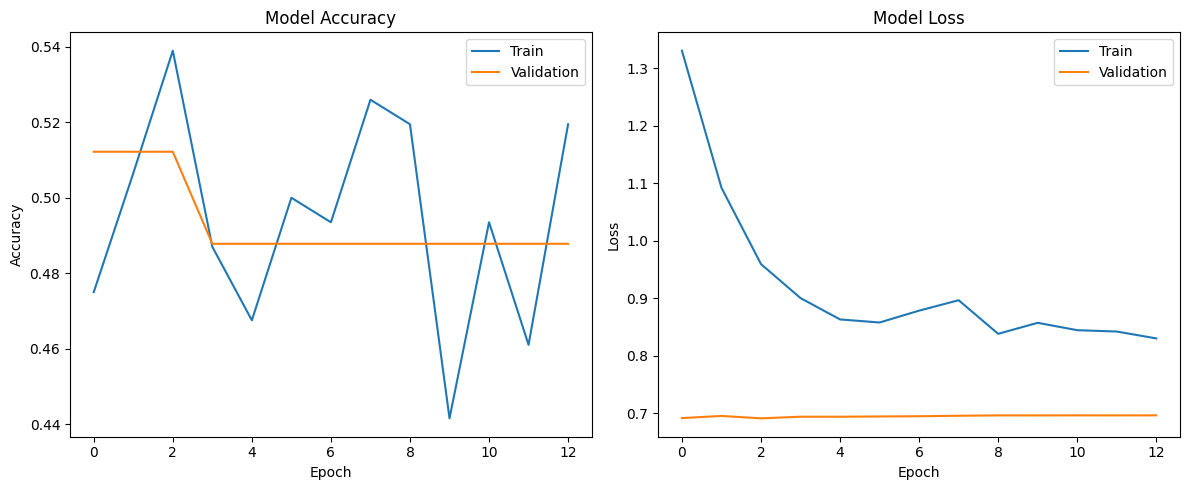

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout, BatchNormalization,
                                     concatenate)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# 1. QR Property Extraction Functions
# ====================================================
def calculate_print_quality_features(image):
    """Extract print quality metrics"""
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    edge_sharpness = laplacian.var()
    contrast = np.max(image) - np.min(image)
    return [edge_sharpness, contrast]

def analyze_structural_patterns(image):
    """Analyze QR structural elements"""
    _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    finder_region = binary[:21, :21]
    finder_score = np.mean(finder_region == 255)
    return [finder_score]

def extract_qr_features(image):
    """Combine quality metrics"""
    # Resize image to standard size for feature extraction
    image = cv2.resize(image, (128, 128))
    features = []
    features += calculate_print_quality_features(image)
    features += analyze_structural_patterns(image)
    return np.array(features)

# 2. Data Loading and Preparation
# ===============================
def load_images(folder, label):
    """Load and preprocess images"""
    images, labels = [], []
    for fname in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, fname), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
            labels.append(label)
    return images, labels

# Define dataset paths (change these paths as needed)
original_path = "/content/drive/MyDrive/Datasets/QR_Classifier/First Print"
counterfeit_path = "/content/drive/MyDrive/Datasets/QR_Classifier/Second Print"

# Load images
orig_imgs, orig_labels = load_images(original_path, 0)
fake_imgs, fake_labels = load_images(counterfeit_path, 1)

# Combine images and labels
X_images = orig_imgs + fake_imgs
y = np.array(orig_labels + fake_labels)

# Resize all images to (128, 128) for consistency
X_images = [cv2.resize(img, (128,128)) for img in X_images]

# Extract handcrafted features on resized images
X_features = np.array([extract_qr_features(img) for img in X_images])

# 3. Hybrid Model Architecture
# ============================
def create_hybrid_model(img_shape, num_features):
    # Image processing branch
    img_input = Input(shape=img_shape, name='image_input')
    x = Conv2D(32, (3,3), activation='relu')(img_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2,2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3,3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2,2)(x)
    x = Flatten()(x)

    # Feature processing branch
    feat_input = Input(shape=(num_features,), name='feature_input')
    y_branch = Dense(8, activation='relu')(feat_input)

    # Combined model
    combined = concatenate([x, y_branch])
    z = Dense(32, activation='relu')(combined)
    output = Dense(1, activation='sigmoid')(z)

    model = Model(inputs=[img_input, feat_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')])
    return model

# 4. Data Preparation
# ===================
# Split dataset into training and testing sets
(X_train_img, X_test_img,
 X_train_feat, X_test_feat,
 y_train, y_test) = train_test_split(
    np.array(X_images), X_features, y,
    test_size=0.2, stratify=y, random_state=42
)

# Normalize images: scale pixel values to [0,1]
X_train_img = np.array([x.astype('float32')/255.0 for x in X_train_img])
X_test_img = np.array([x.astype('float32')/255.0 for x in X_test_img])
# Add channel dimension for grayscale images
X_train_img = X_train_img[..., np.newaxis]
X_test_img = X_test_img[..., np.newaxis]

# Normalize handcrafted features
feat_scaler = StandardScaler()
X_train_feat = feat_scaler.fit_transform(X_train_feat).astype(np.float32)
X_test_feat = feat_scaler.transform(X_test_feat).astype(np.float32)

# 5. Corrected Data Pipeline
# ==========================
# Create a train_datagen for augmentation
train_datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    brightness_range=[0.95,1.05],
    fill_mode='constant',
    cval=255
)

# Custom generator that shuffles indices and applies augmentation
def hybrid_generator(images, features, labels, batch_size=8):
    num_samples = images.shape[0]
    indices = np.arange(num_samples)
    while True:
        np.random.shuffle(indices)
        for i in range(0, num_samples, batch_size):
            batch_idx = indices[i:i+batch_size]
            batch_images = images[batch_idx]
            # Apply augmentation on each image in the batch
            aug_images = np.array([train_datagen.random_transform(img) for img in batch_images])
            batch_features = features[batch_idx]
            batch_labels = labels[batch_idx]
            yield (aug_images, batch_features), batch_labels

# Create TensorFlow Dataset from the generator
output_signature = (
    (
        tf.TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, X_train_feat.shape[1]), dtype=tf.float32)
    ),
    tf.TensorSpec(shape=(None,), dtype=tf.int32)
)

train_dataset = tf.data.Dataset.from_generator(
    lambda: hybrid_generator(X_train_img, X_train_feat, y_train, batch_size=8),
    output_signature=output_signature
)

# 6. Model Training
# =================
hybrid_model = create_hybrid_model((128,128,1), X_train_feat.shape[1])

callbacks = [
    EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=3)
]

history = hybrid_model.fit(
    train_dataset,
    steps_per_epoch=len(X_train_img)//8,
    epochs=50,
    validation_data=([X_test_img, X_test_feat], y_test),
    callbacks=callbacks,
    class_weight={0: 1.5, 1: 1}  # Add class weights
)

# 7. Evaluation
# =============
y_pred = (hybrid_model.predict([X_test_img, X_test_feat]) > 0.5).astype(int)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 8. Visualization of Training History
# =====================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# 9. Deployment-ready Prediction
# ==============================
def authenticate_qrcode(image_path):
    """End-to-end authentication pipeline"""
    # Load and preprocess image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))

    # Extract features
    features = extract_qr_features(img)
    features = feat_scaler.transform([features])

    # Prepare image array
    img_array = np.array([img.astype('float32')/255.0])[..., np.newaxis]

    # Predict probability
    proba = hybrid_model.predict([img_array, features])[0][0]
    return {
        'authentic': proba < 0.5,
        'confidence': 1 - abs(proba - 0.5)*2
    }

# Optionally, save the model
hybrid_model.save('qr_authentication_hybrid.h5')


In [ ]:
def hybrid_generator(images, labels, batch_size=8):
    num_samples = len(images)
    indices = np.arange(num_samples)

    while True:
        np.random.shuffle(indices)
        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_images = []
            batch_features = []

            # Process each image individually
            for idx in batch_indices:
                img = images[idx].copy()

                # Apply augmentation
                img = train_datagen.random_transform(img)

                # Recalculate features from augmented image
                features = extract_qr_features(img)

                batch_images.append(img)
                batch_features.append(features)

            # Convert to arrays
            batch_images = np.array(batch_images)[..., np.newaxis].astype('float32')/255.0
            batch_features = feat_scaler.transform(np.array(batch_features))

            yield (batch_images, batch_features), labels[batch_indices]

In [ ]:
def create_enhanced_hybrid_model(img_shape, num_features):
    # Image branch
    img_input = Input(shape=img_shape)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(img_input)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2,2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2,2)(x)
    x = Flatten()(x)

    # Feature branch
    feat_input = Input(shape=(num_features,))
    y = Dense(16, activation='relu')(feat_input)
    y = BatchNormalization()(y)
    y = Dropout(0.2)(y)

    # Combined
    combined = concatenate([x, y])
    z = Dense(64, activation='relu', kernel_regularizer='l2')(combined)
    z = Dropout(0.5)(z)
    output = Dense(1, activation='sigmoid')(z)

    model = Model(inputs=[img_input, feat_input], outputs=output)
    model.compile(Adam(learning_rate=1e-5),
                 loss='binary_crossentropy',
                 metrics=['accuracy',
                         tf.keras.metrics.Precision(name='prec'),
                         tf.keras.metrics.Recall(name='rec')])
    return model

In [ ]:
# Recalculate class weights
class_counts = np.bincount(y_train)
total = len(y_train)
class_weights = {
    0: total / (2 * class_counts[0]),
    1: total / (2 * class_counts[1])
}

# New callbacks
callbacks = [
    EarlyStopping(patience=20, monitor='val_prec', mode='max', restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5, monitor='val_loss')
]

# Train with validation split
history = hybrid_model.fit(
    train_dataset,
    steps_per_epoch=len(X_train_img)//8,
    epochs=100,
    validation_data=([X_test_img, X_test_feat], y_test),
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INVALID_ARGUMENT:  TypeError: hybrid_generator() got multiple values for argument 'batch_size'
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/dataset_ops.py", line 865, in get_iterator
    return self._iterators[iterator_id]
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^

KeyError: np.int64(1)


During handling of the above exception, another exception occurred:


Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/dataset_ops.py", line 867, in get_iterator
    iterator = iter(self._generator(*self._args.pop(iterator_id)))
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "<ipython-input-14-d0602005f4ec>", line 164, in <lambda>
    lambda: hybrid_generator(X_train_img, X_train_feat, y_train, batch_size=8),
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

TypeError: hybrid_generator() got multiple values for argument 'batch_size'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_8]]
  (1) INVALID_ARGUMENT:  TypeError: hybrid_generator() got multiple values for argument 'batch_size'
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/dataset_ops.py", line 865, in get_iterator
    return self._iterators[iterator_id]
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^

KeyError: np.int64(1)


During handling of the above exception, another exception occurred:


Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/dataset_ops.py", line 867, in get_iterator
    iterator = iter(self._generator(*self._args.pop(iterator_id)))
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "<ipython-input-14-d0602005f4ec>", line 164, in <lambda>
    lambda: hybrid_generator(X_train_img, X_train_feat, y_train, batch_size=8),
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

TypeError: hybrid_generator() got multiple values for argument 'batch_size'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_multi_step_on_iterator_27570]

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout, BatchNormalization,
                                     concatenate)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# 1. QR Property Extraction Functions
# ====================================================
def calculate_print_quality_features(image):
    """Extract print quality metrics"""
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    edge_sharpness = laplacian.var()
    contrast = np.max(image) - np.min(image)
    return [edge_sharpness, contrast]

def analyze_structural_patterns(image):
    """Analyze QR structural elements"""
    _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    finder_region = binary[:21, :21]
    finder_score = np.mean(finder_region == 255)
    return [finder_score]

def extract_qr_features(image):
    """Combine quality metrics. Ensure the image is in uint8 format."""
    image = image.astype(np.uint8)
    image = cv2.resize(image, (128, 128))
    features = []
    features += calculate_print_quality_features(image)
    features += analyze_structural_patterns(image)
    return np.array(features)

# 2. Data Loading and Preparation
# ===============================
def load_images(folder, label):
    """Load and preprocess images"""
    images, labels = [], []
    for fname in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, fname), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
            labels.append(label)
    return images, labels

# Define dataset paths (adjust these paths as needed)
original_path = "/content/drive/MyDrive/Datasets/QR_Classifier/First Print"
counterfeit_path = "/content/drive/MyDrive/Datasets/QR_Classifier/Second Print"

# Load images
orig_imgs, orig_labels = load_images(original_path, 0)
fake_imgs, fake_labels = load_images(counterfeit_path, 1)

# Combine images and labels
X_images = orig_imgs + fake_imgs
y = np.array(orig_labels + fake_labels)

# Resize all images to (128, 128) for consistency
X_images = [cv2.resize(img, (128,128)) for img in X_images]

# Extract handcrafted features on resized images
X_features = np.array([extract_qr_features(img) for img in X_images])

# 3. Enhanced Hybrid Model Architecture
# ============================
def create_enhanced_hybrid_model(img_shape, num_features):
    # Image branch
    img_input = Input(shape=img_shape, name='image_input')
    x = Conv2D(32, (3,3), activation='relu', padding='same')(img_input)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2,2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2,2)(x)
    x = Flatten()(x)

    # Feature branch
    feat_input = Input(shape=(num_features,), name='feature_input')
    y_branch = Dense(16, activation='relu')(feat_input)
    y_branch = BatchNormalization()(y_branch)
    y_branch = Dropout(0.2)(y_branch)

    # Combined
    combined = concatenate([x, y_branch])
    z = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(combined)
    z = Dropout(0.5)(z)
    output = Dense(1, activation='sigmoid')(z)

    model = Model(inputs=[img_input, feat_input], outputs=output)
    model.compile(Adam(learning_rate=1e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(name='prec'),
                           tf.keras.metrics.Recall(name='rec')])
    return model

# 4. Data Preparation
# ===================
# Split dataset into training and testing sets
(X_train_img, X_test_img,
 X_train_feat, X_test_feat,
 y_train, y_test) = train_test_split(
    np.array(X_images), X_features, y,
    test_size=0.2, stratify=y, random_state=42
)

# Normalize images: scale pixel values to [0,1]
X_train_img = np.array([x.astype('float32')/255.0 for x in X_train_img])
X_test_img = np.array([x.astype('float32')/255.0 for x in X_test_img])
# Add channel dimension for grayscale images
X_train_img = X_train_img[..., np.newaxis]
X_test_img = X_test_img[..., np.newaxis]

# Normalize handcrafted features
feat_scaler = StandardScaler()
X_train_feat = feat_scaler.fit_transform(X_train_feat).astype(np.float32)
X_test_feat = feat_scaler.transform(X_test_feat).astype(np.float32)

# 5. Corrected Data Pipeline (with Feature Recalculation After Augmentation)
# ==========================
train_datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    brightness_range=[0.95,1.05],
    fill_mode='constant',
    cval=255
)

def hybrid_generator(images, labels, batch_size=8):
    num_samples = images.shape[0]
    indices = np.arange(num_samples)
    while True:
        np.random.shuffle(indices)
        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_images = []
            batch_features = []
            # Process each image individually without removing the channel dimension
            for idx in batch_indices:
                img = images[idx].copy()  # img shape is (128, 128, 1)
                # Remove the channel dimension temporarily for augmentation
                img_2d = np.squeeze(img)
                # Apply augmentation transformation (expects a 2D array for grayscale)
                img_aug = train_datagen.random_transform(img_2d)
                # Recalculate features on the augmented image
                features = extract_qr_features(img_aug)
                batch_images.append(img_aug)
                batch_features.append(features)
            # Convert to arrays and add channel dimension back
            batch_images = np.array(batch_images)[..., np.newaxis].astype('float32')/255.0
            batch_features = feat_scaler.transform(np.array(batch_features))
            yield (batch_images, batch_features), labels[batch_indices]

# Create TensorFlow Dataset with explicit output_signature
output_signature = (
    (
        tf.TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, X_train_feat.shape[1]), dtype=tf.float32)
    ),
    tf.TensorSpec(shape=(None,), dtype=tf.int32)
)

train_dataset = tf.data.Dataset.from_generator(
    lambda: hybrid_generator(X_train_img, y_train, batch_size=8),
    output_signature=output_signature
)

# 6. Improved Training Configuration
# =================
# Recalculate class weights
class_counts = np.bincount(y_train)
total = len(y_train)
class_weights = {
    0: total / (2 * class_counts[0]),
    1: total / (2 * class_counts[1])
}

# Create the enhanced hybrid model
hybrid_model = create_enhanced_hybrid_model((128,128,1), X_train_feat.shape[1])

callbacks = [
    EarlyStopping(patience=20, monitor='val_prec', mode='max', restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5, monitor='val_loss')
]

history = hybrid_model.fit(
    train_dataset,
    steps_per_epoch=len(X_train_img)//8,
    epochs=100,
    validation_data=([X_test_img, X_test_feat], y_test),
    callbacks=callbacks,
    class_weight=class_weights
)

# 7. Post-Training Optimization: Optimal Threshold Selection
# =================
y_val_pred = hybrid_model.predict([X_test_img, X_test_feat])
y_val_pred = y_val_pred.flatten()
thresholds = np.linspace(0.3, 0.7, 100)
f1_scores = [f1_score(y_test, (y_val_pred > t).astype(int)) for t in thresholds]
optimal_threshold = thresholds[np.argmax(f1_scores)]
print("Optimal Threshold:", optimal_threshold)

# Final evaluation with optimized threshold
y_pred = (y_val_pred > optimal_threshold).astype(int)
print("Final Classification Report:")
print(classification_report(y_test, y_pred))
print("\nFinal Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 8. Visualization of Training History
# =====================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# 9. Deployment-ready Prediction
# ==============================
def authenticate_qrcode(image_path):
    """End-to-end authentication pipeline"""
    # Load and preprocess image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))

    # Extract features (from the non-augmented image)
    features = extract_qr_features(img)
    features = feat_scaler.transform([features])

    # Prepare image array
    img_array = np.array([img.astype('float32')/255.0])[..., np.newaxis]

    # Predict probability
    proba = hybrid_model.predict([img_array, features])[0][0]
    return {
        'authentic': proba < optimal_threshold,
        'confidence': 1 - abs(proba - optimal_threshold)*2
    }

# Optionally, save the model
hybrid_model.save('qr_authentication_hybrid.h5')


Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
ValueError: Input arrays must be multi-channel 2D images.
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "<ipython-input-4-c1589ced91d1>", line 158, in hybrid_generator
    img_aug = train_datagen.random_transform(img_2d)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py", line 1460, in random_transform
    return self.apply_transform(x, params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py", line 1413, in apply_transform
    x = apply_affine_transform(
        ^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py", line 1815, in apply_affine_transform
    raise ValueError("Input arrays must be multi-channel 2D images.")

ValueError: Input arrays must be multi-channel 2D images.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_19932]

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 869ms/step - accuracy: 0.4472 - loss: 2.4003 - prec: 0.4410 - rec: 0.5286 - val_accuracy: 0.5122 - val_loss: 1.9558 - val_prec: 0.5172 - val_rec: 0.7143 - learning_rate: 1.0000e-05
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 828ms/step - accuracy: 0.5452 - loss: 2.0224 - prec: 0.5811 - rec: 0.6562 - val_accuracy: 0.5122 - val_loss: 1.9465 - val_prec: 1.0000 - val_rec: 0.0476 - learning_rate: 1.0000e-05
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 795ms/step - accuracy: 0.5532 - loss: 2.0311 - prec: 0.5774 - rec: 0.4355 - val_accuracy: 0.4878 - val_loss: 1.9384 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 825ms/step - accuracy: 0.4503 - loss: 2.0260 - prec: 0.5406 - rec: 0.4448 - val_accuracy: 0.4634 - val_loss: 1.9293 - val_prec: 0.4815 - val_rec: 0.6190 - learning_rate: 1.0000e-05
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 861ms/step - accuracy: 0.4690 - loss: 2.0077 - prec: 

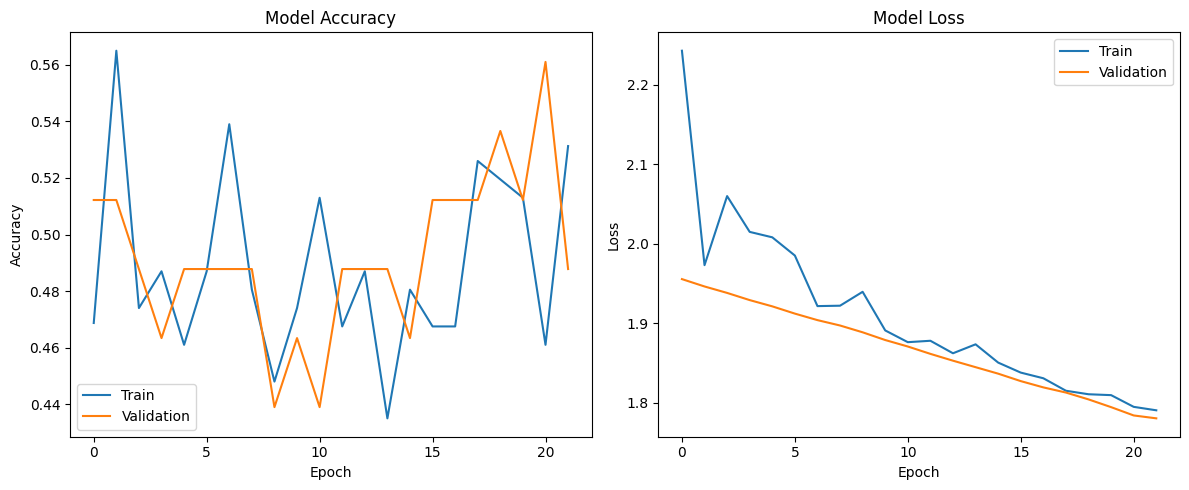

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout, BatchNormalization,
                                     concatenate)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# 1. QR Property Extraction Functions
# ====================================================
def calculate_print_quality_features(image):
    """Extract print quality metrics"""
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    edge_sharpness = laplacian.var()
    contrast = np.max(image) - np.min(image)
    return [edge_sharpness, contrast]

def analyze_structural_patterns(image):
    """Analyze QR structural elements"""
    _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    finder_region = binary[:21, :21]
    finder_score = np.mean(finder_region == 255)
    return [finder_score]

def extract_qr_features(image):
    """Combine quality metrics. Ensure the image is in uint8 format."""
    image = image.astype(np.uint8)
    image = cv2.resize(image, (128, 128))
    features = []
    features += calculate_print_quality_features(image)
    features += analyze_structural_patterns(image)
    return np.array(features)

# 2. Data Loading and Preparation
# ===============================
def load_images(folder, label):
    """Load and preprocess images"""
    images, labels = [], []
    for fname in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, fname), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
            labels.append(label)
    return images, labels

# Define dataset paths (adjust these paths as needed)
original_path = "/content/drive/MyDrive/Datasets/QR_Classifier/First Print"
counterfeit_path = "/content/drive/MyDrive/Datasets/QR_Classifier/Second Print"

# Load images
orig_imgs, orig_labels = load_images(original_path, 0)
fake_imgs, fake_labels = load_images(counterfeit_path, 1)

# Combine images and labels
X_images = orig_imgs + fake_imgs
y = np.array(orig_labels + fake_labels)

# Resize all images to (128, 128) for consistency
X_images = [cv2.resize(img, (128,128)) for img in X_images]

# Extract handcrafted features on resized images
X_features = np.array([extract_qr_features(img) for img in X_images])

# 3. Enhanced Hybrid Model Architecture
# ============================
def create_enhanced_hybrid_model(img_shape, num_features):
    # Image branch
    img_input = Input(shape=img_shape, name='image_input')
    x = Conv2D(32, (3,3), activation='relu', padding='same')(img_input)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2,2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2,2)(x)
    x = Flatten()(x)

    # Feature branch
    feat_input = Input(shape=(num_features,), name='feature_input')
    y_branch = Dense(16, activation='relu')(feat_input)
    y_branch = BatchNormalization()(y_branch)
    y_branch = Dropout(0.2)(y_branch)

    # Combined
    combined = concatenate([x, y_branch])
    z = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(combined)
    z = Dropout(0.5)(z)
    output = Dense(1, activation='sigmoid')(z)

    model = Model(inputs=[img_input, feat_input], outputs=output)
    model.compile(Adam(learning_rate=1e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(name='prec'),
                           tf.keras.metrics.Recall(name='rec')])
    return model

# 4. Data Preparation
# ===================
# Split dataset into training and testing sets
(X_train_img, X_test_img,
 X_train_feat, X_test_feat,
 y_train, y_test) = train_test_split(
    np.array(X_images), X_features, y,
    test_size=0.2, stratify=y, random_state=42
)

# Normalize images: scale pixel values to [0,1]
X_train_img = np.array([x.astype('float32')/255.0 for x in X_train_img])
X_test_img = np.array([x.astype('float32')/255.0 for x in X_test_img])
# Add channel dimension for grayscale images
X_train_img = X_train_img[..., np.newaxis]
X_test_img = X_test_img[..., np.newaxis]

# Normalize handcrafted features
feat_scaler = StandardScaler()
X_train_feat = feat_scaler.fit_transform(X_train_feat).astype(np.float32)
X_test_feat = feat_scaler.transform(X_test_feat).astype(np.float32)

# 5. Corrected Data Pipeline (with Feature Recalculation After Augmentation)
# ==========================
train_datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    brightness_range=[0.95,1.05],
    fill_mode='constant',
    cval=255
)

def hybrid_generator(images, labels, batch_size=8):
    num_samples = images.shape[0]
    indices = np.arange(num_samples)
    while True:
        np.random.shuffle(indices)
        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_images = []
            batch_features = []
            # Process each image individually
            for idx in batch_indices:
                img = images[idx].copy()  # img shape is (128,128,1)
                # Convert to 2D for augmentation by removing the channel dimension
                img_2d = np.squeeze(img)  # shape: (128,128)
                # Convert grayscale image to 3-channel (required by random_transform)
                img_3ch = cv2.cvtColor(img_2d, cv2.COLOR_GRAY2RGB)
                # Apply augmentation transformation
                img_aug_3ch = train_datagen.random_transform(img_3ch)
                # Convert back to grayscale
                img_aug = cv2.cvtColor(img_aug_3ch, cv2.COLOR_RGB2GRAY)
                # Recalculate features on the augmented image
                features = extract_qr_features(img_aug)
                batch_images.append(img_aug)
                batch_features.append(features)
            # Convert to arrays and add channel dimension back
            batch_images = np.array(batch_images)[..., np.newaxis].astype('float32')/255.0
            batch_features = feat_scaler.transform(np.array(batch_features))
            yield (batch_images, batch_features), labels[batch_indices]

# Create TensorFlow Dataset with explicit output_signature
output_signature = (
    (
        tf.TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, X_train_feat.shape[1]), dtype=tf.float32)
    ),
    tf.TensorSpec(shape=(None,), dtype=tf.int32)
)

train_dataset = tf.data.Dataset.from_generator(
    lambda: hybrid_generator(X_train_img, y_train, batch_size=8),
    output_signature=output_signature
)

# 6. Improved Training Configuration
# =================
# Recalculate class weights
class_counts = np.bincount(y_train)
total = len(y_train)
class_weights = {
    0: total / (2 * class_counts[0]),
    1: total / (2 * class_counts[1])
}

# Create the enhanced hybrid model
hybrid_model = create_enhanced_hybrid_model((128,128,1), X_train_feat.shape[1])

callbacks = [
    EarlyStopping(patience=20, monitor='val_prec', mode='max', restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5, monitor='val_loss')
]

history = hybrid_model.fit(
    train_dataset,
    steps_per_epoch=len(X_train_img)//8,
    epochs=100,
    validation_data=([X_test_img, X_test_feat], y_test),
    callbacks=callbacks,
    class_weight=class_weights
)

# 7. Post-Training Optimization: Optimal Threshold Selection
# =================
y_val_pred = hybrid_model.predict([X_test_img, X_test_feat])
y_val_pred = y_val_pred.flatten()
thresholds = np.linspace(0.3, 0.7, 100)
f1_scores = [f1_score(y_test, (y_val_pred > t).astype(int)) for t in thresholds]
optimal_threshold = thresholds[np.argmax(f1_scores)]
print("Optimal Threshold:", optimal_threshold)

# Final evaluation with optimized threshold
y_pred = (y_val_pred > optimal_threshold).astype(int)
print("Final Classification Report:")
print(classification_report(y_test, y_pred))
print("\nFinal Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 8. Visualization of Training History
# =====================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# 9. Deployment-ready Prediction
# ==============================
def authenticate_qrcode(image_path):
    """End-to-end authentication pipeline"""
    # Load and preprocess image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))

    # Extract features (from the non-augmented image)
    features = extract_qr_features(img)
    features = feat_scaler.transform([features])

    # Prepare image array
    img_array = np.array([img.astype('float32')/255.0])[..., np.newaxis]

    # Predict probability
    proba = hybrid_model.predict([img_array, features])[0][0]
    return {
        'authentic': proba < optimal_threshold,
        'confidence': 1 - abs(proba - optimal_threshold)*2
    }

# Optionally, save the model
hybrid_model.save('qr_authentication_hybrid.h5')


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 895ms/step - accuracy: 0.4214 - loss: 1.5433 - prec: 0.4146 - rec: 0.4806 - val_accuracy: 0.5122 - val_loss: 1.3117 - val_prec: 0.5122 - val_rec: 1.0000 - learning_rate: 1.0000e-05
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 892ms/step - accuracy: 0.5737 - loss: 1.4225 - prec: 0.5626 - rec: 0.6048 - val_accuracy: 0.5122 - val_loss: 1.3051 - val_prec: 0.5122 - val_rec: 1.0000 - learning_rate: 1.0000e-05
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 866ms/step - accuracy: 0.4351 - loss: 1.4387 - prec: 0.4397 - rec: 0.3926 - val_accuracy: 0.5122 - val_loss: 1.2979 - val_prec: 0.5122 - val_rec: 1.0000 - learning_rate: 1.0000e-05
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 897ms/step - accuracy: 0.4601 - loss: 1.4118 - prec: 0.4141 - rec: 0.4919 - val_accuracy: 0.5122 - val_loss: 1.2907 - val_prec: 0.5122 - val_rec: 1.0000 - learning_rate: 1.0000e-05
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5112 - loss: 1.3550 - prec: 0.5159 - re

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


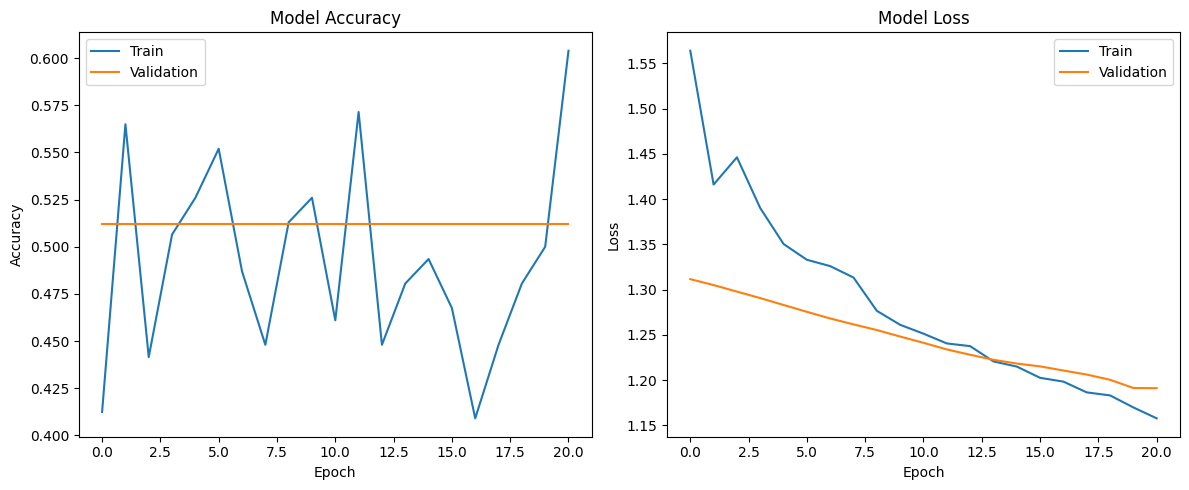

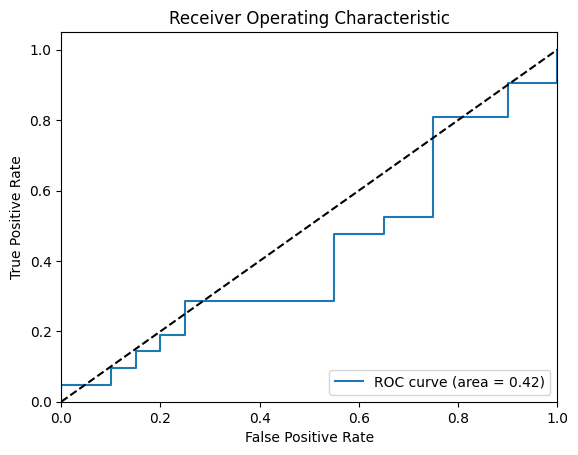

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout, BatchNormalization,
                                     concatenate)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
from skimage.feature import local_binary_pattern

# -------------------------------
# 1. Enhanced QR Feature Extraction Functions
# -------------------------------
def calculate_print_quality_features(image):
    """Extract print quality metrics"""
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    edge_sharpness = laplacian.var()
    contrast = np.max(image) - np.min(image)
    return [edge_sharpness, contrast]

def analyze_structural_patterns(image):
    """Analyze QR structural elements"""
    _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    finder_region = binary[:21, :21]
    finder_score = np.mean(finder_region == 255)
    return [finder_score]

def extract_lbp_features(image, P=8, R=1):
    """Extract Local Binary Patterns (LBP) features"""
    lbp = local_binary_pattern(image, P, R, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, P + 3),
                             range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

def extract_qr_features_extended(image):
    """Combine basic and texture features for QR code"""
    # Ensure image is uint8 and resized to 128x128
    image = image.astype(np.uint8)
    image = cv2.resize(image, (128, 128))
    basic_feats = np.concatenate([calculate_print_quality_features(image),
                                   analyze_structural_patterns(image)])
    lbp_feats = extract_lbp_features(image)
    return np.concatenate([basic_feats, lbp_feats])

# For compatibility with our previous code, we alias:
extract_qr_features = extract_qr_features_extended

# -------------------------------
# 2. Data Loading and Preparation
# -------------------------------
def load_images(folder, label):
    """Load and preprocess images"""
    images, labels = [], []
    for fname in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, fname), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
            labels.append(label)
    return images, labels

# Define dataset paths (adjust these paths as needed)
original_path = "/content/drive/MyDrive/Datasets/QR_Classifier/First Print"
counterfeit_path = "/content/drive/MyDrive/Datasets/QR_Classifier/Second Print"

# Load images
orig_imgs, orig_labels = load_images(original_path, 0)
fake_imgs, fake_labels = load_images(counterfeit_path, 1)

# Combine images and labels
X_images = orig_imgs + fake_imgs
y = np.array(orig_labels + fake_labels)

# Resize all images to (128, 128) for consistency
X_images = [cv2.resize(img, (128,128)) for img in X_images]

# Extract extended handcrafted features on resized images
X_features = np.array([extract_qr_features(img) for img in X_images])

# -------------------------------
# 3. Enhanced Hybrid Model Architecture (v2)
# -------------------------------
def create_enhanced_hybrid_model_v2(img_shape, num_features):
    # Image branch
    img_input = Input(shape=img_shape, name='image_input')
    x = Conv2D(32, (3,3), activation='relu', padding='same')(img_input)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2,2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2,2)(x)
    x = Dropout(0.3)(x)

    # Additional block for deeper features
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2,2)(x)
    x = Flatten()(x)

    # Feature branch
    feat_input = Input(shape=(num_features,), name='feature_input')
    y_branch = Dense(16, activation='relu')(feat_input)
    y_branch = BatchNormalization()(y_branch)
    y_branch = Dropout(0.2)(y_branch)

    # Combined
    combined = concatenate([x, y_branch])
    z = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(combined)
    z = Dropout(0.5)(z)
    output = Dense(1, activation='sigmoid')(z)

    model = Model(inputs=[img_input, feat_input], outputs=output)
    model.compile(Adam(learning_rate=1e-5),
                  loss=focal_loss(gamma=2., alpha=0.25),
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(name='prec'),
                           tf.keras.metrics.Recall(name='rec')])
    return model

# -------------------------------
# 4. Data Preparation and Normalization
# -------------------------------
(X_train_img, X_test_img,
 X_train_feat, X_test_feat,
 y_train, y_test) = train_test_split(
    np.array(X_images), X_features, y,
    test_size=0.2, stratify=y, random_state=42
)

# Normalize images: scale pixel values to [0,1]
X_train_img = np.array([x.astype('float32')/255.0 for x in X_train_img])
X_test_img = np.array([x.astype('float32')/255.0 for x in X_test_img])
# Add channel dimension for grayscale images
X_train_img = X_train_img[..., np.newaxis]
X_test_img = X_test_img[..., np.newaxis]

# Normalize handcrafted features
feat_scaler = StandardScaler()
X_train_feat = feat_scaler.fit_transform(X_train_feat).astype(np.float32)
X_test_feat = feat_scaler.transform(X_test_feat).astype(np.float32)

# -------------------------------
# 5. Corrected Data Pipeline (with Feature Recalculation After Augmentation)
# -------------------------------
train_datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    brightness_range=[0.95,1.05],
    fill_mode='constant',
    cval=255
)

def hybrid_generator(images, labels, batch_size=8):
    num_samples = images.shape[0]
    indices = np.arange(num_samples)
    while True:
        np.random.shuffle(indices)
        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_images = []
            batch_features = []
            # Process each image individually
            for idx in batch_indices:
                img = images[idx].copy()  # img shape: (128,128,1)
                # Remove the channel dimension for augmentation
                img_2d = np.squeeze(img)  # shape: (128,128)
                # Convert grayscale to 3-channel (needed by random_transform)
                img_3ch = cv2.cvtColor(img_2d, cv2.COLOR_GRAY2RGB)
                # Apply augmentation
                img_aug_3ch = train_datagen.random_transform(img_3ch)
                # Convert back to grayscale
                img_aug = cv2.cvtColor(img_aug_3ch, cv2.COLOR_RGB2GRAY)
                # Ensure augmented image is uint8
                img_aug = np.uint8(np.clip(img_aug, 0, 255))
                # Recalculate features on the augmented image
                features = extract_qr_features(img_aug)
                batch_images.append(img_aug)
                batch_features.append(features)
            # Convert to arrays and add channel dimension back
            batch_images = np.array(batch_images)[..., np.newaxis].astype('float32')/255.0
            batch_features = feat_scaler.transform(np.array(batch_features))
            yield (batch_images, batch_features), labels[batch_indices]

# Create TensorFlow Dataset with explicit output_signature
output_signature = (
    (
        tf.TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, X_train_feat.shape[1]), dtype=tf.float32)
    ),
    tf.TensorSpec(shape=(None,), dtype=tf.int32)
)

train_dataset = tf.data.Dataset.from_generator(
    lambda: hybrid_generator(X_train_img, y_train, batch_size=8),
    output_signature=output_signature
)

# -------------------------------
# 6. Improved Training Configuration
# -------------------------------
# Recalculate class weights
class_counts = np.bincount(y_train)
total = len(y_train)
class_weights = {
    0: total / (2 * class_counts[0]),
    1: total / (2 * class_counts[1])
}

# Create the enhanced hybrid model (v2)
hybrid_model = create_enhanced_hybrid_model_v2((128,128,1), X_train_feat.shape[1])

callbacks = [
    EarlyStopping(patience=20, monitor='val_prec', mode='max', restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5, monitor='val_loss')
]

history = hybrid_model.fit(
    train_dataset,
    steps_per_epoch=len(X_train_img)//8,
    epochs=100,
    validation_data=([X_test_img, X_test_feat], y_test),
    callbacks=callbacks,
    class_weight=class_weights
)

# -------------------------------
# 7. Post-Training Optimization: Optimal Threshold Selection
# -------------------------------
y_val_pred = hybrid_model.predict([X_test_img, X_test_feat])
y_val_pred = y_val_pred.flatten()
thresholds = np.linspace(0.3, 0.7, 100)
f1_scores = [f1_score(y_test, (y_val_pred > t).astype(int)) for t in thresholds]
optimal_threshold = thresholds[np.argmax(f1_scores)]
print("Optimal Threshold:", optimal_threshold)

# Final evaluation with optimized threshold
y_pred = (y_val_pred > optimal_threshold).astype(int)
print("Final Classification Report:")
print(classification_report(y_test, y_pred))
print("\nFinal Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# -------------------------------
# 8. Visualization of Training History
# -------------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# 9. ROC Curve Visualization (Optional)
# -------------------------------
fpr, tpr, thresholds_roc = roc_curve(y_test, y_val_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# -------------------------------
# 10. Deployment-ready Prediction
# -------------------------------
def authenticate_qrcode(image_path):
    """End-to-end authentication pipeline"""
    # Load and preprocess image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))

    # Extract features (from the non-augmented image)
    features = extract_qr_features(img)
    features = feat_scaler.transform([features])

    # Prepare image array
    img_array = np.array([img.astype('float32')/255.0])[..., np.newaxis]

    # Predict probability
    proba = hybrid_model.predict([img_array, features])[0][0]
    return {
        'authentic': proba < optimal_threshold,
        'confidence': 1 - abs(proba - optimal_threshold)*2
    }

# Optionally, save the model
hybrid_model.save('qr_authentication_hybrid.h5')


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 66s 302ms/step - accuracy: 0.6411 - loss: 2.5526 - val_accuracy: 0.4878 - val_loss: 0.6530 - learning_rate: 1.0000e-04
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 275ms/step - accuracy: 0.6070 - loss: 1.7176 - val_accuracy: 0.4878 - val_loss: 0.8167 - learning_rate: 1.0000e-04
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 272ms/step - accuracy: 0.7369 - loss: 0.5655 - val_accuracy: 0.4878 - val_loss: 1.0619 - learning_rate: 1.0000e-04
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 319ms/step - accuracy: 0.7177 - loss: 0.6176 - val_accuracy: 0.4878 - val_loss: 1.3464 - learning_rate: 1.0000e-04
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 360ms/step - accuracy: 0.7954 - loss: 0.4179 - val_accuracy: 0.4878 - val_loss: 1.4745 - learning_rate: 5.0000e-05
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step - accuracy: 0.8941 - loss: 0.3456 - val_accuracy: 0.4878 - val_loss: 1.7484 - learning_rate: 5.0000e-05
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 315ms/step - accu

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


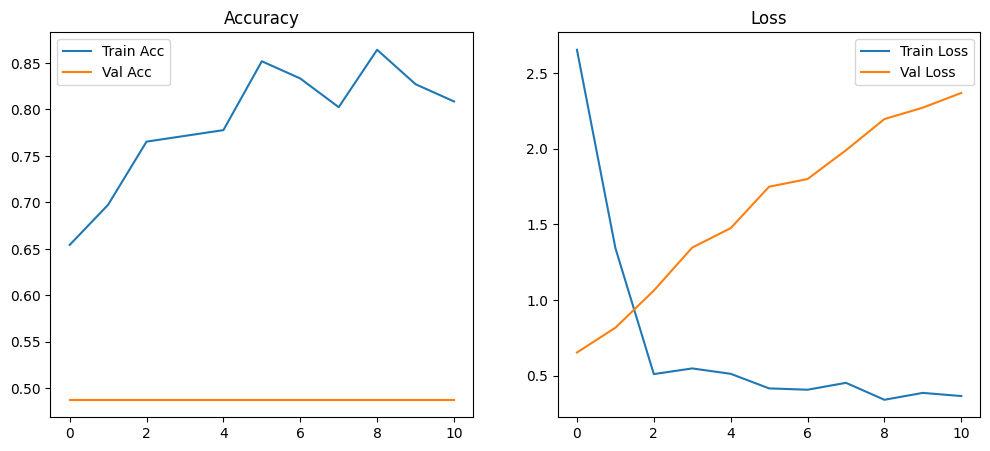

In [ ]:
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# -------------------------------------------------
# 1. Utilities for QR Detection & Extraction
# -------------------------------------------------
def enhance_image(image):
    """
    Enhance image using morphological ops and adaptive threshold.
    Adjust kernel sizes as needed.
    """
    # Convert to grayscale if not already
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Adaptive threshold
    thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 21, 5)

    # Morphological ops
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)

    return morph

def find_qr_contour(image):
    """
    Finds the largest contour that might correspond to the outer QR boundary.
    Returns the 4 corner points if found, else None.
    """
    # Find contours
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None

    # Sort contours by area (descending)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    for cnt in contours:
        # Approximate polygon
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        if len(approx) == 4:
            return approx.reshape(4, 2)
    return None

def warp_qr(image, corners):
    """
    Warps the image using the corner points to get a top-down view of the QR code.
    corners: (4,2) array of points (x,y).
    """
    # Sort corners (Rectify)
    # A common approach: sort by sum(x+y) or difference to get consistent ordering
    rect = np.zeros((4,2), dtype="float32")

    s = corners.sum(axis=1)
    rect[0] = corners[np.argmin(s)]
    rect[2] = corners[np.argmax(s)]

    diff = np.diff(corners, axis=1)
    rect[1] = corners[np.argmin(diff)]
    rect[3] = corners[np.argmax(diff)]

    # Compute width and height
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # Destination array
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # Warp
    M = cv2.getPerspectiveTransform(rect, dst)
    warp = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warp

def detect_and_extract_qr_layers(image):
    """
    Detects outer QR code, warps it, then tries to detect an inner code.
    Returns (outer_qr, inner_qr) as images.
    If not found, returns None for that layer.
    """
    # Enhance image for contour detection
    enhanced = enhance_image(image)

    # Find largest contour (outer QR)
    corners = find_qr_contour(enhanced)
    if corners is None:
        return None, None

    outer_qr = warp_qr(image, corners)

    # Now try to detect an inner code if present
    # We can do the same process on outer_qr
    enhanced_inner = enhance_image(outer_qr)
    inner_corners = find_qr_contour(enhanced_inner)

    if inner_corners is not None:
        inner_qr = warp_qr(outer_qr, inner_corners)
    else:
        inner_qr = None

    return outer_qr, inner_qr

# -------------------------------------------------
# 2. Build Dataset from Extracted Layers
# -------------------------------------------------
def build_dataset(image_paths, labels):
    """
    For each image path, detect outer & inner QR layers, store them,
    or fallback to original if detection fails.
    Returns arrays of images (outer) and features (optionally).
    """
    extracted_imgs = []
    final_labels = []

    for path, label in zip(image_paths, labels):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        outer_qr, inner_qr = detect_and_extract_qr_layers(img)

        if outer_qr is not None:
            # Use outer QR as final image
            resized = cv2.resize(outer_qr, (128,128))
            extracted_imgs.append(resized)
            final_labels.append(label)

            # Optionally, if you want to keep the inner QR as well:
            # if inner_qr is not None:
            #     resized_inner = cv2.resize(inner_qr, (128,128))
            #     extracted_imgs.append(resized_inner)
            #     final_labels.append(label)
        else:
            # fallback: store the original
            fallback = cv2.resize(img, (128,128))
            extracted_imgs.append(fallback)
            final_labels.append(label)

    extracted_imgs = np.array(extracted_imgs)
    final_labels = np.array(final_labels)
    return extracted_imgs, final_labels

# -------------------------------------------------
# 3. CNN Model for Classification
# -------------------------------------------------
def create_cnn_model(input_shape=(128,128,1)):
    """
    Simple CNN for classification. Adjust layers as needed.
    """
    inp = Input(shape=input_shape)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(inp)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inp, out)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# -------------------------------------------------
# 4. Example: Training Pipeline
# -------------------------------------------------
def example_training_pipeline(data_folder_original, data_folder_counterfeit):
    """
    Example pipeline that:
    1) Collects image paths & labels
    2) Extracts outer & inner layers
    3) Trains a CNN on the extracted images
    """
    # Collect image paths
    original_paths = [os.path.join(data_folder_original, f)
                      for f in os.listdir(data_folder_original) if f.endswith('.png') or f.endswith('.jpg')]
    counterfeit_paths = [os.path.join(data_folder_counterfeit, f)
                         for f in os.listdir(data_folder_counterfeit) if f.endswith('.png') or f.endswith('.jpg')]

    all_paths = original_paths + counterfeit_paths
    labels = np.array([0]*len(original_paths) + [1]*len(counterfeit_paths))

    # Build dataset from extracted QR layers
    extracted_imgs, final_labels = build_dataset(all_paths, labels)

    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(extracted_imgs, final_labels,
                                                        test_size=0.2, stratify=final_labels, random_state=42)

    # Normalize images to [0,1] and add channel dimension
    X_train = X_train[..., np.newaxis].astype('float32')/255.0
    X_test  = X_test[..., np.newaxis].astype('float32')/255.0

    # Create & train model
    model = create_cnn_model(input_shape=(128,128,1))

    callbacks = [
        EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=3, monitor='val_loss')
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=8,
        callbacks=callbacks
    )

    # Evaluate
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Return model, history
    return model, history

# -------------------------------------------------
# 5. Main Execution (Example)
# -------------------------------------------------
if __name__ == "__main__":
    # Suppose you have data in the following folders
    # Adjust these paths
    data_folder_original = "/content/drive/MyDrive/Datasets/QR_Classifier/First Print"
    data_folder_counterfeit = "/content/drive/MyDrive/Datasets/QR_Classifier/Second Print"

    # Train
    final_model, hist = example_training_pipeline(data_folder_original, data_folder_counterfeit)

    # Plot
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(hist.history['accuracy'], label='Train Acc')
    plt.plot(hist.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title("Loss")
    plt.show()

    # Save final model
    final_model.save("qr_code_classifier.h5")


In [ ]:
!pip install --upgrade scikit-image


Extracting features...


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━

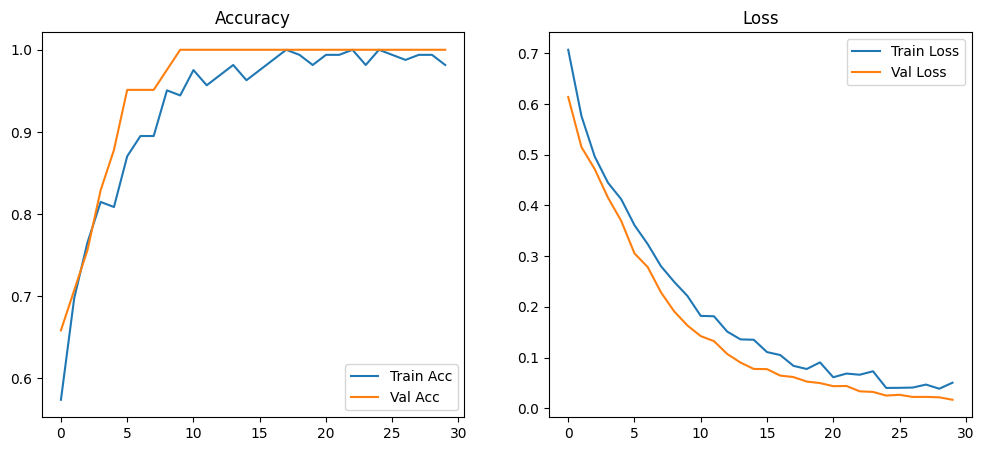

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from skimage.feature import graycomatrix, graycoprops

import tensorflow as tf
import tensorflow_hub as hub  # If needed for EfficientNet from TF Hub
from tensorflow.keras.layers import (Input, Dense, Dropout, BatchNormalization,
                                     GlobalAveragePooling2D, concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

# -------------------------------
# 1. GLCM Feature Extraction
# -------------------------------
def extract_glcm_features(gray_img, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    """
    Compute GLCM features (contrast, dissimilarity, homogeneity, energy, correlation, ASM)
    averaged over multiple distances & angles.

    :param gray_img: Grayscale image (2D NumPy array)
    :param distances: list of pixel distances
    :param angles: list of angles in radians
    :return: 1D NumPy array of GLCM feature means
    """
    # Ensure 8-bit grayscale
    gray_img = gray_img.astype(np.uint8)

    # Compute GLCM
    glcm = greycomatrix(gray_img, distances=distances, angles=angles,
                        levels=256, symmetric=True, normed=True)

    features = []
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    for prop in props:
        vals = greycoprops(glcm, prop)
        mean_val = np.mean(vals)
        features.append(mean_val)

    return np.array(features, dtype=np.float32)

# -------------------------------
# 2. Data Loading
# -------------------------------
def load_images_and_labels(original_dir, counterfeit_dir):
    """
    Loads images from two folders (original, counterfeit).
    Returns a list of images and corresponding labels (0=original, 1=counterfeit).
    """
    original_paths = [os.path.join(original_dir, f)
                      for f in os.listdir(original_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    counterfeit_paths = [os.path.join(counterfeit_dir, f)
                         for f in os.listdir(counterfeit_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))]

    X_imgs = []
    y_labels = []

    # Label 0 for original
    for p in original_paths:
        img = cv2.imread(p, cv2.IMREAD_COLOR)  # We'll do color for EfficientNet
        if img is not None:
            X_imgs.append(img)
            y_labels.append(0)

    # Label 1 for counterfeit
    for p in counterfeit_paths:
        img = cv2.imread(p, cv2.IMREAD_COLOR)
        if img is not None:
            X_imgs.append(img)
            y_labels.append(1)

    return X_imgs, np.array(y_labels)

# -------------------------------
# 3. EfficientNet Feature Extraction (Image Embeddings)
# -------------------------------
def create_efficientnet_encoder():
    """
    Create a pretrained EfficientNetB0 model for extracting image embeddings
    (excluding final classification layers).
    """
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # We'll get a 1280-d vector for B0
    encoder = tf.keras.Model(inputs=base_model.input, outputs=x)

    # Freeze base layers for faster training (optional)
    for layer in base_model.layers:
        layer.trainable = False

    return encoder

def preprocess_efficientnet(img):
    """
    Preprocess image to 224x224 with 3 channels for EfficientNet.
    """
    img_resized = cv2.resize(img, (224,224))
    img_resized = img_resized[..., ::-1]  # BGR -> RGB if needed
    img_resized = img_resized.astype(np.float32)
    return preprocess_input(img_resized)  # From tf.keras.applications.efficientnet

# -------------------------------
# 4. Hybrid Model (CNN Embeddings + GLCM Features)
# -------------------------------
def build_hybrid_model(effnet_dim, glcm_dim):
    """
    Build a hybrid model that merges:
    - effnet_dim: Dimension of EfficientNet embeddings (e.g. 1280 for B0)
    - glcm_dim: Dimension of GLCM features (6 in our example)
    """
    # Image embedding input
    img_input = Input(shape=(effnet_dim,), name='img_embedding')

    # GLCM feature input
    glcm_input = Input(shape=(glcm_dim,), name='glcm_features')

    # Merge
    merged = concatenate([img_input, glcm_input])

    x = Dense(256, activation='relu')(merged)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[img_input, glcm_input], outputs=out)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# -------------------------------
# 5. Putting It All Together
# -------------------------------
def main_pipeline(original_dir, counterfeit_dir):
    # 1. Load images and labels
    X_imgs, y = load_images_and_labels(original_dir, counterfeit_dir)

    # 2. Prepare arrays for embeddings & GLCM
    #    We'll build them for each image
    effnet_encoder = create_efficientnet_encoder()  # Pretrained EfficientNet

    glcm_features_list = []
    effnet_embeddings_list = []

    print("Extracting features...")
    for img in X_imgs:
        # GLCM extraction (on grayscale)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        glcm_feats = extract_glcm_features(gray)  # We'll define this function below
        glcm_features_list.append(glcm_feats)

        # EfficientNet embedding
        prep_img = preprocess_efficientnet(img)  # shape=(224,224,3)
        prep_img = np.expand_dims(prep_img, axis=0)  # (1,224,224,3)
        emb = effnet_encoder.predict(prep_img)
        effnet_embeddings_list.append(emb[0])  # shape=(1280,)

    X_glcm = np.array(glcm_features_list)              # shape=(N,6)
    X_effnet = np.array(effnet_embeddings_list)        # shape=(N,1280) for B0
    print("Done. Shapes:", X_glcm.shape, X_effnet.shape)

    # 3. Train/Test Split
    X_train_glcm, X_test_glcm, X_train_eff, X_test_eff, y_train, y_test = train_test_split(
        X_glcm, X_effnet, y, test_size=0.2, stratify=y, random_state=42
    )

    # Scale GLCM features
    scaler = StandardScaler()
    X_train_glcm = scaler.fit_transform(X_train_glcm)
    X_test_glcm = scaler.transform(X_test_glcm)

    # 4. Build Hybrid Model
    hybrid_net = build_hybrid_model(effnet_dim=X_train_eff.shape[1],
                                    glcm_dim=X_train_glcm.shape[1])

    # 5. Train
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    ]

    history = hybrid_net.fit(
        [X_train_eff, X_train_glcm], y_train,
        validation_data=([X_test_eff, X_test_glcm], y_test),
        epochs=30, batch_size=8, callbacks=callbacks
    )

    # 6. Evaluate
    y_pred_prob = hybrid_net.predict([X_test_eff, X_test_glcm])
    y_pred = (y_pred_prob > 0.5).astype(int)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # 7. Optional: Evaluate with different thresholds
    best_f1 = 0
    best_t = 0.5
    for t in np.linspace(0.1, 0.9, 50):
        yp = (y_pred_prob > t).astype(int)
        f1 = f1_score(y_test, yp)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    print(f"Best threshold={best_t:.2f} with F1={best_f1:.3f}")

    # 8. Plot training curves
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title("Loss")
    plt.show()

    return hybrid_net, scaler, best_t

# 6. Extra: GLCM extraction function (like we used in the pipeline)
def extract_glcm_features(gray_img):
    """
    Example GLCM function that returns 6 features:
    contrast, dissimilarity, homogeneity, energy, correlation, ASM
    for distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
    then averaged across angles.
    """

    gray_img = gray_img.astype(np.uint8)
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(gray_img, distances=distances, angles=angles,
                           levels=256, symmetric=True, normed=True)

    features = []
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    for prop in props:
        val = graycoprops(glcm, prop)
        features.append(val.mean())
    return np.array(features, dtype=np.float32)

# 7. Entry Point
if __name__ == "__main__":
    # Example usage
    # Replace with your actual folders containing .png/.jpg
    original_dir = "/content/drive/MyDrive/Datasets/QR_Classifier/First Print"
    counterfeit_dir = "/content/drive/MyDrive/Datasets/QR_Classifier/Second Print"



    model, glcm_scaler, best_threshold = main_pipeline(original_dir, counterfeit_dir)

    # Save model if needed
    model.save("glcm_efficientnet_hybrid.h5")
